In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, auc
import torch
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
import xgboost as xgb
import lightgbm as lgbm
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score,cross_validate
from ray import tune
from concurrent.futures import ThreadPoolExecutor
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import importlib
import all_merics
importlib.reload(all_merics)
from all_merics import *
import mlp_model
importlib.reload(mlp_model)
from mlp_model import *

import matplotlib.pyplot as plt

In [2]:
df_exo = pd.read_csv('data/exo_gapen_descri_0106_sxnx.csv', index_col=0)
df_tox = pd.read_csv('data/tox_gapen_descri_0106_sxnx.csv', index_col=0)
df_all = pd.concat([df_exo, df_tox], axis=0)
df_all_random = shuffle(df_all,  random_state=1)
df_all_random.head()

,label,standard_smiles,sx_ave1,sx_ave2,sx_ave3,sx_ave4,sx_ave5,sx_ave6,sx_ave7,sx_ave8,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
939,0.0,CC(C)C(=O)OCC(C)c1ccccc1,90.396552,75.168831,103.873563,78.907692,71.632353,78.686275,84.588235,80.657895,...,0,0,0,0,0,0,0,0,0,0
355,1.0,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCc2cccs2)CC1,89.943925,84.810458,86.877551,87.665025,88.000000,78.128755,74.591954,78.641026,...,0,0,0,0,0,0,0,1,0,0
614,1.0,FC(F)OC(F)(F)C(F)Cl,78.842105,80.733333,57.250000,64.666667,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1535,1.0,Clc1ccc(-c2cc(Cl)cc(Cl)c2Cl)c(Cl)c1,180.222222,84.807692,129.275862,109.789474,114.277778,109.500000,68.750000,74.000000,...,0,0,0,0,0,0,0,0,0,0
337,1.0,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,172.800000,128.187500,148.402597,134.396552,113.875000,137.043478,79.714286,22.000000,...,0,2,0,0,0,0,0,0,0,0


In [3]:
col_list = list(df_all_random.columns.values)
gapen_all = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10', 'sx_std1', 'sx_std2', 'sx_std3', 'sx_std4', 'sx_std5', 'sx_std6', 'sx_std7', 'sx_std8', 'sx_std9', 'sx_std10', 'nx_ave1', 'nx_ave2', 'nx_ave3', 'nx_ave4', 'nx_ave5', 'nx_ave6', 'nx_ave7', 'nx_ave8', 'nx_ave9', 'nx_ave10', 'nx_std1', 'nx_std2', 'nx_std3', 'nx_std4', 'nx_std5', 'nx_std6', 'nx_std7', 'nx_std8', 'nx_std9', 'nx_std10', 'oldnbe', 'oldstd', 'newnbe', 'newstd', 'max_gap', 'sx_ave1*sx_ave2', 'sx_ave1*sx_ave3', 'sx_ave1*sx_ave4', 'sx_ave1*sx_ave5', 'sx_ave1*sx_ave6', 'sx_ave1*sx_ave7', 'sx_ave1*sx_ave8', 'sx_ave1*sx_ave9', 'sx_ave1*sx_ave10', 'sx_ave2*sx_ave3', 'sx_ave2*sx_ave4', 'sx_ave2*sx_ave5', 'sx_ave2*sx_ave6', 'sx_ave2*sx_ave7', 'sx_ave2*sx_ave8', 'sx_ave2*sx_ave9', 'sx_ave2*sx_ave10', 'sx_ave3*sx_ave4', 'sx_ave3*sx_ave5', 'sx_ave3*sx_ave6', 'sx_ave3*sx_ave7', 'sx_ave3*sx_ave8', 'sx_ave3*sx_ave9', 'sx_ave3*sx_ave10', 'sx_ave4*sx_ave5', 'sx_ave4*sx_ave6', 'sx_ave4*sx_ave7', 'sx_ave4*sx_ave8', 'sx_ave4*sx_ave9', 'sx_ave4*sx_ave10', 'sx_ave5*sx_ave6', 'sx_ave5*sx_ave7', 'sx_ave5*sx_ave8', 'sx_ave5*sx_ave9', 'sx_ave5*sx_ave10', 'sx_ave6*sx_ave7', 'sx_ave6*sx_ave8', 'sx_ave6*sx_ave9', 'sx_ave6*sx_ave10', 'sx_ave7*sx_ave8', 'sx_ave7*sx_ave9', 'sx_ave7*sx_ave10', 'sx_ave8*sx_ave9', 'sx_ave8*sx_ave10', 'sx_ave9*sx_ave10', 'sx_std1*sx_std2', 'sx_std1*sx_std3', 'sx_std1*sx_std4', 'sx_std1*sx_std5', 'sx_std1*sx_std6', 'sx_std1*sx_std7', 'sx_std1*sx_std8', 'sx_std1*sx_std9', 'sx_std1*sx_std10', 'sx_std2*sx_std3', 'sx_std2*sx_std4', 'sx_std2*sx_std5', 'sx_std2*sx_std6', 'sx_std2*sx_std7', 'sx_std2*sx_std8', 'sx_std2*sx_std9', 'sx_std2*sx_std10', 'sx_std3*sx_std4', 'sx_std3*sx_std5', 'sx_std3*sx_std6', 'sx_std3*sx_std7', 'sx_std3*sx_std8', 'sx_std3*sx_std9', 'sx_std3*sx_std10', 'sx_std4*sx_std5', 'sx_std4*sx_std6', 'sx_std4*sx_std7', 'sx_std4*sx_std8', 'sx_std4*sx_std9', 'sx_std4*sx_std10', 'sx_std5*sx_std6', 'sx_std5*sx_std7', 'sx_std5*sx_std8', 'sx_std5*sx_std9', 'sx_std5*sx_std10', 'sx_std6*sx_std7', 'sx_std6*sx_std8', 'sx_std6*sx_std9', 'sx_std6*sx_std10', 'sx_std7*sx_std8', 'sx_std7*sx_std9', 'sx_std7*sx_std10', 'sx_std8*sx_std9', 'sx_std8*sx_std10', 'sx_std9*sx_std10', 'nx_ave1*nx_ave2', 'nx_ave1*nx_ave3', 'nx_ave1*nx_ave4', 'nx_ave1*nx_ave5', 'nx_ave1*nx_ave6', 'nx_ave1*nx_ave7', 'nx_ave1*nx_ave8', 'nx_ave1*nx_ave9', 'nx_ave1*nx_ave10', 'nx_ave2*nx_ave3', 'nx_ave2*nx_ave4', 'nx_ave2*nx_ave5', 'nx_ave2*nx_ave6', 'nx_ave2*nx_ave7', 'nx_ave2*nx_ave8', 'nx_ave2*nx_ave9', 'nx_ave2*nx_ave10', 'nx_ave3*nx_ave4', 'nx_ave3*nx_ave5', 'nx_ave3*nx_ave6', 'nx_ave3*nx_ave7', 'nx_ave3*nx_ave8', 'nx_ave3*nx_ave9', 'nx_ave3*nx_ave10', 'nx_ave4*nx_ave5', 'nx_ave4*nx_ave6', 'nx_ave4*nx_ave7', 'nx_ave4*nx_ave8', 'nx_ave4*nx_ave9', 'nx_ave4*nx_ave10', 'nx_ave5*nx_ave6', 'nx_ave5*nx_ave7', 'nx_ave5*nx_ave8', 'nx_ave5*nx_ave9', 'nx_ave5*nx_ave10', 'nx_ave6*nx_ave7', 'nx_ave6*nx_ave8', 'nx_ave6*nx_ave9', 'nx_ave6*nx_ave10', 'nx_ave7*nx_ave8', 'nx_ave7*nx_ave9', 'nx_ave7*nx_ave10', 'nx_ave8*nx_ave9', 'nx_ave8*nx_ave10', 'nx_ave9*nx_ave10', 'nx_std1*nx_std2', 'nx_std1*nx_std3', 'nx_std1*nx_std4', 'nx_std1*nx_std5', 'nx_std1*nx_std6', 'nx_std1*nx_std7', 'nx_std1*nx_std8', 'nx_std1*nx_std9', 'nx_std1*nx_std10', 'nx_std2*nx_std3', 'nx_std2*nx_std4', 'nx_std2*nx_std5', 'nx_std2*nx_std6', 'nx_std2*nx_std7', 'nx_std2*nx_std8', 'nx_std2*nx_std9', 'nx_std2*nx_std10', 'nx_std3*nx_std4', 'nx_std3*nx_std5', 'nx_std3*nx_std6', 'nx_std3*nx_std7', 'nx_std3*nx_std8', 'nx_std3*nx_std9', 'nx_std3*nx_std10', 'nx_std4*nx_std5', 'nx_std4*nx_std6', 'nx_std4*nx_std7', 'nx_std4*nx_std8', 'nx_std4*nx_std9', 'nx_std4*nx_std10', 'nx_std5*nx_std6', 'nx_std5*nx_std7', 'nx_std5*nx_std8', 'nx_std5*nx_std9', 'nx_std5*nx_std10', 'nx_std6*nx_std7', 'nx_std6*nx_std8', 'nx_std6*nx_std9', 'nx_std6*nx_std10', 'nx_std7*nx_std8', 'nx_std7*nx_std9', 'nx_std7*nx_std10', 'nx_std8*nx_std9', 'nx_std8*nx_std10', 'nx_std9*nx_std10', ]
gapen_10 = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10']
gapen_20 = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10', 'sx_std1', 'sx_std2', 'sx_std3', 'sx_std4', 'sx_std5', 'sx_std6', 'sx_std7', 'sx_std8', 'sx_std9', 'sx_std10',]
gapen_40 = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10', 'sx_std1', 'sx_std2', 'sx_std3', 'sx_std4', 'sx_std5', 'sx_std6', 'sx_std7', 'sx_std8', 'sx_std9', 'sx_std10', 'nx_ave1', 'nx_ave2', 'nx_ave3', 'nx_ave4', 'nx_ave5', 'nx_ave6', 'nx_ave7', 'nx_ave8', 'nx_ave9', 'nx_ave10', 'nx_std1', 'nx_std2', 'nx_std3', 'nx_std4', 'nx_std5', 'nx_std6', 'nx_std7', 'nx_std8', 'nx_std9', 'nx_std10',]
gapen_nonbe = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10', 'sx_std1', 'sx_std2', 'sx_std3', 'sx_std4', 'sx_std5', 'sx_std6', 'sx_std7', 'sx_std8', 'sx_std9', 'sx_std10', 'nx_ave1', 'nx_ave2', 'nx_ave3', 'nx_ave4', 'nx_ave5', 'nx_ave6', 'nx_ave7', 'nx_ave8', 'nx_ave9', 'nx_ave10', 'nx_std1', 'nx_std2', 'nx_std3', 'nx_std4', 'nx_std5', 'nx_std6', 'nx_std7', 'nx_std8', 'nx_std9', 'nx_std10', 'sx_ave1*sx_ave2', 'sx_ave1*sx_ave3', 'sx_ave1*sx_ave4', 'sx_ave1*sx_ave5', 'sx_ave1*sx_ave6', 'sx_ave1*sx_ave7', 'sx_ave1*sx_ave8', 'sx_ave1*sx_ave9', 'sx_ave1*sx_ave10', 'sx_ave2*sx_ave3', 'sx_ave2*sx_ave4', 'sx_ave2*sx_ave5', 'sx_ave2*sx_ave6', 'sx_ave2*sx_ave7', 'sx_ave2*sx_ave8', 'sx_ave2*sx_ave9', 'sx_ave2*sx_ave10', 'sx_ave3*sx_ave4', 'sx_ave3*sx_ave5', 'sx_ave3*sx_ave6', 'sx_ave3*sx_ave7', 'sx_ave3*sx_ave8', 'sx_ave3*sx_ave9', 'sx_ave3*sx_ave10', 'sx_ave4*sx_ave5', 'sx_ave4*sx_ave6', 'sx_ave4*sx_ave7', 'sx_ave4*sx_ave8', 'sx_ave4*sx_ave9', 'sx_ave4*sx_ave10', 'sx_ave5*sx_ave6', 'sx_ave5*sx_ave7', 'sx_ave5*sx_ave8', 'sx_ave5*sx_ave9', 'sx_ave5*sx_ave10', 'sx_ave6*sx_ave7', 'sx_ave6*sx_ave8', 'sx_ave6*sx_ave9', 'sx_ave6*sx_ave10', 'sx_ave7*sx_ave8', 'sx_ave7*sx_ave9', 'sx_ave7*sx_ave10', 'sx_ave8*sx_ave9', 'sx_ave8*sx_ave10', 'sx_ave9*sx_ave10', 'sx_std1*sx_std2', 'sx_std1*sx_std3', 'sx_std1*sx_std4', 'sx_std1*sx_std5', 'sx_std1*sx_std6', 'sx_std1*sx_std7', 'sx_std1*sx_std8', 'sx_std1*sx_std9', 'sx_std1*sx_std10', 'sx_std2*sx_std3', 'sx_std2*sx_std4', 'sx_std2*sx_std5', 'sx_std2*sx_std6', 'sx_std2*sx_std7', 'sx_std2*sx_std8', 'sx_std2*sx_std9', 'sx_std2*sx_std10', 'sx_std3*sx_std4', 'sx_std3*sx_std5', 'sx_std3*sx_std6', 'sx_std3*sx_std7', 'sx_std3*sx_std8', 'sx_std3*sx_std9', 'sx_std3*sx_std10', 'sx_std4*sx_std5', 'sx_std4*sx_std6', 'sx_std4*sx_std7', 'sx_std4*sx_std8', 'sx_std4*sx_std9', 'sx_std4*sx_std10', 'sx_std5*sx_std6', 'sx_std5*sx_std7', 'sx_std5*sx_std8', 'sx_std5*sx_std9', 'sx_std5*sx_std10', 'sx_std6*sx_std7', 'sx_std6*sx_std8', 'sx_std6*sx_std9', 'sx_std6*sx_std10', 'sx_std7*sx_std8', 'sx_std7*sx_std9', 'sx_std7*sx_std10', 'sx_std8*sx_std9', 'sx_std8*sx_std10', 'sx_std9*sx_std10', 'nx_ave1*nx_ave2', 'nx_ave1*nx_ave3', 'nx_ave1*nx_ave4', 'nx_ave1*nx_ave5', 'nx_ave1*nx_ave6', 'nx_ave1*nx_ave7', 'nx_ave1*nx_ave8', 'nx_ave1*nx_ave9', 'nx_ave1*nx_ave10', 'nx_ave2*nx_ave3', 'nx_ave2*nx_ave4', 'nx_ave2*nx_ave5', 'nx_ave2*nx_ave6', 'nx_ave2*nx_ave7', 'nx_ave2*nx_ave8', 'nx_ave2*nx_ave9', 'nx_ave2*nx_ave10', 'nx_ave3*nx_ave4', 'nx_ave3*nx_ave5', 'nx_ave3*nx_ave6', 'nx_ave3*nx_ave7', 'nx_ave3*nx_ave8', 'nx_ave3*nx_ave9', 'nx_ave3*nx_ave10', 'nx_ave4*nx_ave5', 'nx_ave4*nx_ave6', 'nx_ave4*nx_ave7', 'nx_ave4*nx_ave8', 'nx_ave4*nx_ave9', 'nx_ave4*nx_ave10', 'nx_ave5*nx_ave6', 'nx_ave5*nx_ave7', 'nx_ave5*nx_ave8', 'nx_ave5*nx_ave9', 'nx_ave5*nx_ave10', 'nx_ave6*nx_ave7', 'nx_ave6*nx_ave8', 'nx_ave6*nx_ave9', 'nx_ave6*nx_ave10', 'nx_ave7*nx_ave8', 'nx_ave7*nx_ave9', 'nx_ave7*nx_ave10', 'nx_ave8*nx_ave9', 'nx_ave8*nx_ave10', 'nx_ave9*nx_ave10', 'nx_std1*nx_std2', 'nx_std1*nx_std3', 'nx_std1*nx_std4', 'nx_std1*nx_std5', 'nx_std1*nx_std6', 'nx_std1*nx_std7', 'nx_std1*nx_std8', 'nx_std1*nx_std9', 'nx_std1*nx_std10', 'nx_std2*nx_std3', 'nx_std2*nx_std4', 'nx_std2*nx_std5', 'nx_std2*nx_std6', 'nx_std2*nx_std7', 'nx_std2*nx_std8', 'nx_std2*nx_std9', 'nx_std2*nx_std10', 'nx_std3*nx_std4', 'nx_std3*nx_std5', 'nx_std3*nx_std6', 'nx_std3*nx_std7', 'nx_std3*nx_std8', 'nx_std3*nx_std9', 'nx_std3*nx_std10', 'nx_std4*nx_std5', 'nx_std4*nx_std6', 'nx_std4*nx_std7', 'nx_std4*nx_std8', 'nx_std4*nx_std9', 'nx_std4*nx_std10', 'nx_std5*nx_std6', 'nx_std5*nx_std7', 'nx_std5*nx_std8', 'nx_std5*nx_std9', 'nx_std5*nx_std10', 'nx_std6*nx_std7', 'nx_std6*nx_std8', 'nx_std6*nx_std9', 'nx_std6*nx_std10', 'nx_std7*nx_std8', 'nx_std7*nx_std9', 'nx_std7*nx_std10', 'nx_std8*nx_std9', 'nx_std8*nx_std10', 'nx_std9*nx_std10', ]
descri = ['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea']
# print(col_list)

In [4]:
def featurelabels(df, opt):
    features = df[opt]
    labels = df['label']
    selector = VarianceThreshold(0.0) #排除为0的特征
    features = selector.fit_transform(features)  # 会变成数组
    features = pd.DataFrame(features)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1,
                                                        stratify=labels)

    mean = X_train.mean(skipna=True)
    std = X_train.std(skipna=True) + 0.00001
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    X_train = X_train.fillna(0.0)
    X_test = X_test.fillna(0.0)

    X_train = torch.tensor(X_train.values).to(torch.float32)
    X_test = torch.tensor(X_test.values).to(torch.float32)
    y_train = torch.LongTensor(y_train.values)
    y_test = torch.LongTensor(y_test.values)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = featurelabels(df_all_random, descri)
gapen_descri_list = [gapen_all, descri, gapen_all+descri]
gapen_descri_namelist = ['gapen_all', 'descri', 'gapen_all+descri']

In [5]:
print(X_train.shape[1])
print(X_test.shape)

204
torch.Size([1954, 204])


基线测试 消融实验
SVM Baseline

In [6]:
jixian_res = []
jixian_list = [gapen_10, gapen_20, gapen_40, gapen_nonbe, gapen_all]
def jixian():
    for jx in jixian_list:
        X_train, X_test, y_train, y_test = featurelabels(df_all_random, jx)
        # print(X_train.shape)
        config = {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
        kernel = config.get('kernel') #‘linear’, ‘poly’, ‘rbf’
        C = config.get('C')
        gamma = config.get('gamma')
        clf = SVC(kernel=kernel, C=C, gamma=gamma, class_weight='balanced',)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='balanced_accuracy', n_jobs=5) #balanced_accuracy
        jixian_res.append(np.mean(scores))

    return jixian_res
jixian_res = jixian()


In [89]:
df_res = pd.Series(jixian_res, index=['gapen_10', 'gapen_20', 'gapen_40', 'gapen_nonbe', 'gapen_all'])
df_res.to_csv('results/jixian_xiaorong_0106.csv')

In [7]:
#基线 交叉验证预测验证集概率的AUC曲线
jixian_res_proba = []
jixian_list = [gapen_10, gapen_20, gapen_40, gapen_nonbe, gapen_all]
def jixian():
    for jx in jixian_list:
        X_train, X_test, y_train, y_test = featurelabels(df_all_random, jx)
        # print(X_train.shape)
        config = {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
        kernel = config.get('kernel') #‘linear’, ‘poly’, ‘rbf’
        C = config.get('C')
        gamma = config.get('gamma')
        clf = SVC(kernel=kernel, C=C, gamma=gamma, class_weight='balanced', probability=True)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=kfold, method='predict_proba' , n_jobs=5) #balanced_accuracy
        print(y_pred_cv.shape)
        jixian_res_proba.append(y_pred_cv)
    return jixian_res_proba 
jixian_res_proba  = jixian()

(7816, 2)
(7816, 2)
(7816, 2)
(7816, 2)
(7816, 2)


In [13]:
len(jixian_res_proba)

5

In [18]:
#保存
with open('/results/SVM_baseline_res_proba.pkl', 'wb') as f:
    pickle.dump(jixian_res_proba, f)
with open('/results/SVM_baseline_y_train_truelable.pkl', 'wb') as f:
    pickle.dump(np.array(y_train), f)
#加载
with open('/results/SVM_baseline_res_proba.pkl', 'rb') as f:
    jixian_res_proba = pickle.load(f)

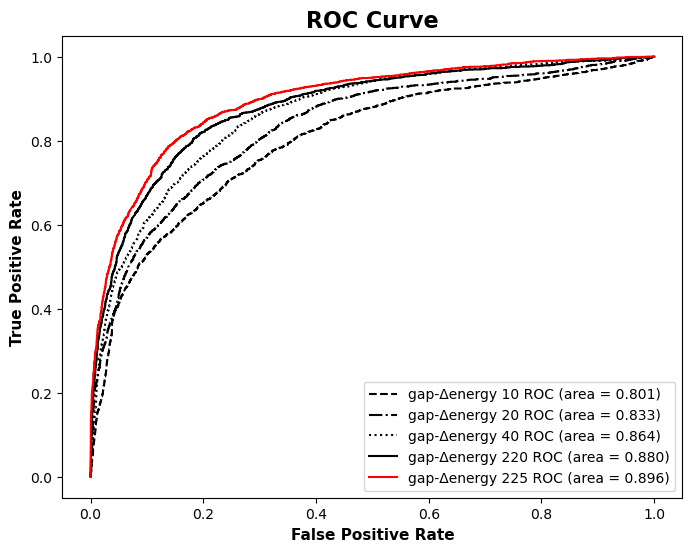

In [16]:
#画AUC图
font= {'family' : 'Times New Roman','fontsize': 16, 'fontweight': 'bold',}
font2= {'family' : 'Times New Roman', 'fontsize': 11, 'fontweight': 'bold'}
xian = ['k--','k-.', 'k:', 'k-','r-']
labels_feature = ['gap-Δenergy 10', 'gap-Δenergy 20', 'gap-Δenergy 40', 'gap-Δenergy 220', 'gap-Δenergy 225']
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.figsize'] = (8, 6)
for i in range(len(jixian_res_proba)):
    fpr, tpr, thersholds = roc_curve(y_train, jixian_res_proba[i][:,1])
    roc_auc = auc(fpr, tpr)
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.plot(fpr, tpr, xian[i], markersize=0.5, label='{obj} ROC (area = {obj2:.3f})'.format(obj=labels_feature[i], obj2=roc_auc))
plt.xlabel('False Positive Rate', fontdict=font2)
plt.ylabel('True Positive Rate', fontdict=font2)
plt.title('ROC Curve', fontdict=font)
plt.legend(loc="lower right")
# plt.savefig('不同特征数量的基线ROC.tif', dpi=400)
plt.show()

正式测试

In [28]:
def train_svm(config, data):
    X_train, y_train = data[0], data[1]
    kernel = config.get('kernel') #‘linear’, ‘poly’, ‘rbf’
    C = config.get('C')
    gamma = config.get('gamma')
    clf = SVC(kernel=kernel, C=C, gamma=gamma, class_weight='balanced',)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='balanced_accuracy', n_jobs=1) #balanced_accuracy
    tune.report(balanced_accuracy=scores.mean())

In [36]:
def train_exotox_svm(datastr, num_samples = 64, ):
    X_train, X_test, y_train, y_test = featurelabels(df_all_random, datastr)
    analysis = tune.run(
        tune.with_parameters(train_svm, data = (X_train, y_train)),
        resources_per_trial={'cpu': 2, },
        num_samples=num_samples,
        config={
            'kernel': tune.choice(['rbf']), #,'linear','poly'
            'C' : tune.loguniform(1, 10),
            "gamma": tune.loguniform(1e-3, 1e-1),
        },

        metric='balanced_accuracy',
        mode='max',
        verbose=2,
    )
    best_trial = analysis.get_best_trial("balanced_accuracy", "max")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation ba: {}".format(best_trial.last_result["balanced_accuracy"]))
    print(f"Loss results: {analysis}")

    scores_test = test_svm(best_trial.config, X_train, X_test, y_train, y_test)
    return scores_test, best_trial.config


In [37]:
def train_split_data_svm(gapen_descri_list = gapen_descri_list):
    all_scores_test = []
    all_configs = []
    for data_str in gapen_descri_list:
        scores_test, config = train_exotox_svm(data_str)
        all_scores_test.append(scores_test)
        all_configs.append(config)
    return all_scores_test, all_configs
all_scores_test , all_configs= train_split_data_svm()

2023-01-06 06:59:04,502	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_svm_8436f_00000,0.746847
train_svm_8436f_00001,0.80062
train_svm_8436f_00002,0.773251
train_svm_8436f_00003,0.753925
train_svm_8436f_00004,0.800759
train_svm_8436f_00005,0.766923
train_svm_8436f_00006,0.810467
train_svm_8436f_00007,0.746193
train_svm_8436f_00008,0.804568
train_svm_8436f_00009,0.745918


2023-01-06 07:00:28,985	INFO tune.py:762 -- Total run time: 84.49 seconds (84.32 seconds for the tuning loop).


Best trial config: {'kernel': 'rbf', 'C': 5.726272656311316, 'gamma': 0.011098898098959432}
Best trial final validation ba: 0.8143465917877151
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f99b24056d0>


2023-01-06 07:00:55,531	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


{'test_acc': 0.8505629477993859, 'test_ba': 0.8238029321255201, 'test_f1': 0.7291280148423005, 'test_auc': 0.9042508235090152, 'test_mcc': 0.627805960689029, 'test_sn': 0.767578125, 'test_sp': 0.8800277392510403}


Trial name,balanced_accuracy
train_svm_c664b_00000,0.897692
train_svm_c664b_00001,0.883714
train_svm_c664b_00002,0.761225
train_svm_c664b_00003,0.893349
train_svm_c664b_00004,0.81499
train_svm_c664b_00005,0.889894
train_svm_c664b_00006,0.885933
train_svm_c664b_00007,0.895804
train_svm_c664b_00008,0.891506
train_svm_c664b_00009,0.88923


2023-01-06 07:02:13,389	INFO tune.py:762 -- Total run time: 77.88 seconds (77.70 seconds for the tuning loop).


Best trial config: {'kernel': 'rbf', 'C': 1.14025491772381, 'gamma': 0.021567766244799023}
Best trial final validation ba: 0.8977629953028459
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f99b112c550>
{'test_acc': 0.901740020470829, 'test_ba': 0.8950066639216366, 'test_f1': 0.8244972577696528, 'test_auc': 0.9524836652652565, 'test_mcc': 0.7596498925476958, 'test_sn': 0.880859375, 'test_sp': 0.9091539528432733}


2023-01-06 07:02:36,807	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_svm_02c23_00000,0.872657
train_svm_02c23_00001,0.87687
train_svm_02c23_00002,0.868895
train_svm_02c23_00003,0.709206
train_svm_02c23_00004,0.877132
train_svm_02c23_00005,0.64542
train_svm_02c23_00006,0.65596
train_svm_02c23_00007,0.874666
train_svm_02c23_00008,0.875912
train_svm_02c23_00009,0.667439


2023-01-06 07:05:24,305	INFO tune.py:762 -- Total run time: 167.50 seconds (167.34 seconds for the tuning loop).


Best trial config: {'kernel': 'rbf', 'C': 1.5186990568510723, 'gamma': 0.0025477559144419606}
Best trial final validation ba: 0.8807134939142693
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f99ac078040>
{'test_acc': 0.8930399181166837, 'test_ba': 0.8790349232836339, 'test_f1': 0.8063021316033364, 'test_auc': 0.9474369636355755, 'test_mcc': 0.7345089176709954, 'test_sn': 0.849609375, 'test_sp': 0.9084604715672677}


In [73]:
df_all_svm = pd.DataFrame(all_scores_test,index = gapen_descri_namelist)
df_all_svm.to_csv('results/svm_0106.csv')
df_config_svm = pd.DataFrame(all_configs,index = gapen_descri_namelist)
df_config_svm.to_csv('results/svm_config_0106.csv')
print(df_all_svm)
print(df_config_svm)

                  test_acc   test_ba   test_f1  test_auc  test_mcc   test_sn  \
gapen_all         0.850563  0.823803  0.729128  0.904251  0.627806  0.767578   
descri            0.901740  0.895007  0.824497  0.952484  0.759650  0.880859   
gapen_all+descri  0.893040  0.879035  0.806302  0.947437  0.734509  0.849609   

                   test_sp  
gapen_all         0.880028  
descri            0.909154  
gapen_all+descri  0.908460  
                 kernel         C     gamma
gapen_all           rbf  5.726273  0.011099
descri              rbf  1.140255  0.021568
gapen_all+descri    rbf  1.518699  0.002548


In [100]:
def train_RF(config, data):
    X_train, y_train = data[0], data[1]
    n_estimators = int(config.get('n_estimators'))
    max_features= config.get('max_features')
    max_depth = int(config.get('max_depth'))
    min_samples_split = int(config.get('min_samples_split'))
    min_samples_leaf = int(config.get('min_samples_leaf'))
    max_leaf_nodes = config.get('max_leaf_nodes')
    clf = RFC(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth,
              min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes,
              class_weight='balanced',random_state=1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='balanced_accuracy', n_jobs=1) #balanced_accuracy
    tune.report(balanced_accuracy=scores.mean())

def train_exotox(datastr,train_clf,test_clf,config_clf, num_samples = 64, ):
    X_train, X_test, y_train, y_test = featurelabels(df_all_random, datastr)
    analysis = tune.run(
        tune.with_parameters(train_clf, data = (X_train, y_train)),
        resources_per_trial={'cpu': 2, },
        num_samples=num_samples,
        config = config_clf,
        metric='balanced_accuracy',
        mode='max',
        verbose=2,
    )
    best_trial = analysis.get_best_trial("balanced_accuracy", "max")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation ba: {}".format(best_trial.last_result["balanced_accuracy"]))
    print(f"Loss results: {analysis}")

    scores_test = test_clf(best_trial.config, X_train, X_test, y_train, y_test)
    return scores_test, best_trial.config

config_RF={
            'n_estimators':tune.quniform(256, 1024, 64),
            'max_features' :tune.choice(['sqrt', 'log2']),
            'max_depth' : tune.quniform(10, 50,1),
            'min_samples_split': tune.quniform(3,15,1),
            'min_samples_leaf': tune.quniform(3,15,1),
            'max_leaf_nodes': None
        }
def train_split_data(train_clf, config_clf, test_clf, gapen_descri_list = gapen_descri_list, ): #公共的
    all_scores_test = []
    all_configs = []
    for data_str in gapen_descri_list:
        scores_test, config = train_exotox(data_str,train_clf,test_clf,config_clf )
        all_scores_test.append(scores_test)
        all_configs.append(config)
    return all_scores_test, all_configs


In [75]:
all_scores_test_RF , all_configs_RF= train_split_data(train_RF,config_RF,test_RF )

2023-01-06 08:08:24,983	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_RF_340de_00000,0.795853
train_RF_340de_00001,0.782453
train_RF_340de_00002,0.794631
train_RF_340de_00003,0.787549
train_RF_340de_00004,0.783447
train_RF_340de_00005,0.793083
train_RF_340de_00006,0.787163
train_RF_340de_00007,0.78667
train_RF_340de_00008,0.785173
train_RF_340de_00009,0.784884


2023-01-06 08:11:52,084	INFO tune.py:762 -- Total run time: 207.11 seconds (206.91 seconds for the tuning loop).


Best trial config: {'n_estimators': 384.0, 'max_features': 'sqrt', 'max_depth': 27.809902437889214, 'min_samples_split': 6.652462701626385, 'min_samples_leaf': 14.509098152667171, 'max_leaf_nodes': None}
Best trial final validation ba: 0.7975548914093894
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f98203355e0>


2023-01-06 08:12:10,569	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


{'test_acc': 0.8485158648925282, 'test_ba': 0.7991125606796117, 'test_f1': 0.7063492063492064, 'test_auc': 0.9042691086598476, 'test_mcc': 0.6044531663460626, 'test_sn': 0.6953125, 'test_sp': 0.9029126213592233}


Trial name,balanced_accuracy
train_RF_ba838_00000,0.877805
train_RF_ba838_00001,0.879541
train_RF_ba838_00002,0.878002
train_RF_ba838_00003,0.880015
train_RF_ba838_00004,0.879066
train_RF_ba838_00005,0.877012
train_RF_ba838_00006,0.874584
train_RF_ba838_00007,0.877109
train_RF_ba838_00008,0.878232
train_RF_ba838_00009,0.880946


2023-01-06 08:14:02,109	INFO tune.py:762 -- Total run time: 111.55 seconds (111.35 seconds for the tuning loop).


Best trial config: {'n_estimators': 704.0, 'max_features': 'sqrt', 'max_depth': 40.74693698003556, 'min_samples_split': 13.66784154040429, 'min_samples_leaf': 4.89107283364304, 'max_leaf_nodes': None}
Best trial final validation ba: 0.8822616509984371
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f98203e0d30>
{'test_acc': 0.9140225179119754, 'test_ba': 0.8894723582697642, 'test_f1': 0.8362573099415204, 'test_auc': 0.9641902251647018, 'test_mcc': 0.7779674759142403, 'test_sn': 0.837890625, 'test_sp': 0.9410540915395285}


2023-01-06 08:14:20,192	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_RF_07c6a_00000,0.855541
train_RF_07c6a_00001,0.854812
train_RF_07c6a_00002,0.855344
train_RF_07c6a_00003,0.862776
train_RF_07c6a_00004,0.853666
train_RF_07c6a_00005,0.861601
train_RF_07c6a_00006,0.854896
train_RF_07c6a_00007,0.869172
train_RF_07c6a_00008,0.859491
train_RF_07c6a_00009,0.85781


2023-01-06 08:17:44,993	INFO tune.py:762 -- Total run time: 204.81 seconds (204.62 seconds for the tuning loop).


Best trial config: {'n_estimators': 320.0, 'max_features': 'sqrt', 'max_depth': 49.88668181954674, 'min_samples_split': 5.286389279326607, 'min_samples_leaf': 7.757511957353781, 'max_leaf_nodes': None}
Best trial final validation ba: 0.8691715373148632
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f984c2ebbb0>
{'test_acc': 0.9078812691914022, 'test_ba': 0.8733448552357836, 'test_f1': 0.82, 'test_auc': 0.9579895273491679, 'test_mcc': 0.7585441812168844, 'test_sn': 0.80078125, 'test_sp': 0.9459084604715673}


In [76]:
# all_scores_test_RF , all_configs_RF= train_split_data(train_RF,config_RF,test_RF )
df_all_RF = pd.DataFrame(all_scores_test_RF,index = gapen_descri_namelist)
df_all_RF.to_csv('results/RF_0106.csv')
df_config_RF = pd.DataFrame(all_configs_RF,index = gapen_descri_namelist)
df_config_RF.to_csv('results/RF_config_0106.csv')
print(df_all_RF)
print(df_config_RF)

                  test_acc   test_ba   test_f1  test_auc  test_mcc   test_sn  \
gapen_all         0.848516  0.799113  0.706349  0.904269  0.604453  0.695312   
descri            0.914023  0.889472  0.836257  0.964190  0.777967  0.837891   
gapen_all+descri  0.907881  0.873345  0.820000  0.957990  0.758544  0.800781   

                   test_sp  
gapen_all         0.902913  
descri            0.941054  
gapen_all+descri  0.945908  
                  n_estimators max_features  max_depth  min_samples_split  \
gapen_all                384.0         sqrt  27.809902           6.652463   
descri                   704.0         sqrt  40.746937          13.667842   
gapen_all+descri         320.0         sqrt  49.886682           5.286389   

                  min_samples_leaf max_leaf_nodes  
gapen_all                14.509098           None  
descri                    4.891073           None  
gapen_all+descri          7.757512           None  


In [111]:
df_exo.shape[0]/df_tox.shape[0]

2.81640625

In [13]:
config_xgb = [{'n_estimators': 384, 'eta': 0.11433808730262854, 'max_depth': 7, 
                    'min_child_weight': 1, 'gamma': 0, 'subsample': 0.9, 'colsample_bytree': 0.9,
                    'reg_lambda': 2.5, 'alpha': 0.6},
                {'n_estimators': 416, 'eta': 0.054890366192422504, 'max_depth': 6, 
                     'min_child_weight': 1, 'gamma': 0, 'subsample': 0.7, 'colsample_bytree': 0.8,
                     'reg_lambda': 1.0, 'alpha': 0.9},
                {'n_estimators': 512, 'eta': 0.04556006862451965, 'max_depth': 7, 
                    'min_child_weight': 1, 'gamma': 0, 'subsample': 1.0, 'colsample_bytree': 0.6,
                    'reg_lambda': 2.5, 'alpha': 1.0}] #gapen,descri,all

config_lgbm = [{'n_estimators': 320, 'learning_rate': 0.04269326560878588, 
                     'max_depth': 6, 'subsample': 0.7,
                     'colsample_bytree': 0.9, 'reg_lambda': 2.5},
                {'n_estimators': 480, 'learning_rate': 0.09034690531177264, 
                      'max_depth': 7, 'subsample': 0.9, 
                      'colsample_bytree': 0.8, 'reg_lambda': 2.5},
                {'n_estimators': 256, 'learning_rate': 0.16558076062084082, 
                    'max_depth': 4.308250053598344, 'subsample': 0.6,
                     'colsample_bytree': 0.8, 'reg_lambda': 0.5}
]

def test_data_again(config_all, test_clf, gapen_descri_list = gapen_descri_list ):
    all_scores_test = []
    all_configs = []
    for config, data_str in zip(config_all, gapen_descri_list):
        X_train, X_test, y_train, y_test = featurelabels(df_all_random, data_str)
        scores_test = test_clf(config, X_train, X_test, y_train, y_test)
        all_scores_test.append(scores_test)

    return all_scores_test

all_scores_test_xgb = test_data_again(config_xgb, test_xgb )
all_scores_test_lgbm = test_data_again(config_lgbm, test_lgbm )

{'test_acc': 0.8833162743091095, 'test_ba': 0.835917183165742, 'test_f1': 0.7678207739307537, 'test_auc': 0.9369588949809292, 'test_mcc': 0.691216261504556, 'test_sn': 0.736328125, 'test_sp': 0.9355062413314841}
{'test_acc': 0.9176049129989765, 'test_ba': 0.8925293645977809, 'test_f1': 0.842311459353575, 'test_auc': 0.9644543440100555, 'test_mcc': 0.7865511002827411, 'test_sn': 0.83984375, 'test_sp': 0.9452149791955617}
{'test_acc': 0.9165813715455476, 'test_ba': 0.8918358833217753, 'test_f1': 0.8406647116324536, 'test_auc': 0.9653970451196254, 'test_mcc': 0.7841663387692213, 'test_sn': 0.83984375, 'test_sp': 0.9438280166435506}
{'test_acc': 0.8679631525076765, 'test_ba': 0.8387412231276006, 'test_f1': 0.7552182163187856, 'test_auc': 0.9329564786321081, 'test_mcc': 0.6654243147878357, 'test_sn': 0.77734375, 'test_sp': 0.9001386962552012}
{'test_acc': 0.9165813715455476, 'test_ba': 0.8912060614597781, 'test_f1': 0.840352595494613, 'test_auc': 0.9641062489164355, 'test_mcc': 0.7838994628

In [14]:
df_all_xgb = pd.DataFrame(all_scores_test_xgb,index = gapen_descri_namelist)
df_all_lgbm = pd.DataFrame(all_scores_test_lgbm,index = gapen_descri_namelist)
df_all_xgb.to_csv('results/XGB_0124.csv')
df_all_lgbm.to_csv('results/LGBM_0124.csv')
df_all_lgbm.head()

,test_acc,test_ba,test_f1,test_auc,test_mcc,test_sn,test_sp
gapen_all,0.867963,0.838741,0.755218,0.932956,0.665424,0.777344,0.900139
descri,0.916581,0.891206,0.840353,0.964106,0.783899,0.837891,0.944521
gapen_all+descri,0.909928,0.887328,0.830116,0.961484,0.768941,0.839844,0.934813


In [112]:
weight = df_exo.shape[0]/df_tox.shape[0]
def train_xgb(config,data):
    X_train, y_train = data[0], data[1]
    n_estimators = int(config.get('n_estimators'))
    eta = config.get('eta')
    min_child_weight= config.get('min_child_weight')
    max_depth = int(config.get('max_depth'))
    gamma = config.get('gamma')
    subsample = config.get('subsample')
    colsample_bytree =config.get('colsample_bytree')
    reg_lambda = config.get('reg_lambda')
    alpha = config.get('alpha')
    clf = XGB(n_estimators=n_estimators, eta= eta, min_child_weight=min_child_weight, max_depth=max_depth,
              gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, reg_lambda=reg_lambda, alpha=alpha,
              scale_pos_weight=weight, eval_metric='auc',booster='gbtree',objective='binary:logistic',
              seed=1, tree_method='exact',n_jobs=1,random_state=1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='balanced_accuracy', n_jobs=2) #balanced_accuracy
    tune.report(balanced_accuracy=scores.mean())

config_xgb={
            'n_estimators':tune.quniform(32, 512, 32),
            'eta': tune.uniform(0.02,0.2),
            'max_depth' : tune.quniform(3, 10,1),
            'min_child_weight': 1,#tune.uniform(0.2,3)
            'gamma': 0,#tune.quniform(0, 1,0.1)
            'subsample': tune.quniform(0.5, 1.0,0.1),
            'colsample_bytree':tune.quniform(0.5,1.0,0.1),
            'reg_lambda':tune.quniform(0,3,0.5),
            'alpha': tune.quniform(0, 1,0.1)
        }
all_scores_test_xgb , all_configs_xgb= train_split_data(train_xgb,config_xgb,test_xgb )
df_all_xgb = pd.DataFrame(all_scores_test_xgb,index = gapen_descri_namelist)
df_all_xgb.to_csv('results/XGB_0106.csv')
df_config_xgb = pd.DataFrame(all_configs_xgb,index = gapen_descri_namelist)
df_config_xgb.to_csv('results/XGB_config_0106.csv')
print(df_all_xgb)
print(df_config_xgb)

2023-01-06 09:42:37,099	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_xgb_5cfa8_00000,0.825053
train_xgb_5cfa8_00001,0.825929
train_xgb_5cfa8_00002,0.827553
train_xgb_5cfa8_00003,0.826882
train_xgb_5cfa8_00004,0.824506
train_xgb_5cfa8_00005,0.827175
train_xgb_5cfa8_00006,0.828693
train_xgb_5cfa8_00007,0.785111
train_xgb_5cfa8_00008,0.827943
train_xgb_5cfa8_00009,0.785761


2023-01-06 09:50:28,904	INFO tune.py:762 -- Total run time: 471.81 seconds (471.59 seconds for the tuning loop).


Best trial config: {'n_estimators': 384.0, 'eta': 0.11433808730262854, 'max_depth': 7.1233683452190055, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 2.5, 'alpha': 0.6000000000000001}
Best trial final validation ba: 0.8301603447061933
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f97e4720f10>


2023-01-06 09:50:47,767	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


{'test_acc': 0.8838280450358239, 'test_ba': 0.836893745665742, 'test_f1': 0.7690742624618515, 'test_auc': 0.9375548554524966, 'test_mcc': 0.6927228697104425, 'test_sn': 0.73828125, 'test_sp': 0.9355062413314841}


Trial name,balanced_accuracy
train_xgb_81707_00000,0.888594
train_xgb_81707_00001,0.886764
train_xgb_81707_00002,0.890958
train_xgb_81707_00003,0.888739
train_xgb_81707_00004,0.888517
train_xgb_81707_00005,0.888205
train_xgb_81707_00006,0.881762
train_xgb_81707_00007,0.88368
train_xgb_81707_00008,0.888659
train_xgb_81707_00009,0.888439


2023-01-06 09:54:08,035	INFO tune.py:762 -- Total run time: 200.28 seconds (200.04 seconds for the tuning loop).


Best trial config: {'n_estimators': 416.0, 'eta': 0.054890366192422504, 'max_depth': 6.843415222520365, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'reg_lambda': 1.0, 'alpha': 0.9}
Best trial final validation ba: 0.8936588668935347
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f98205d3d90>
{'test_acc': 0.9191402251791198, 'test_ba': 0.8967186958217753, 'test_f1': 0.8463035019455253, 'test_auc': 0.9654796669122747, 'test_mcc': 0.7914545498710291, 'test_sn': 0.849609375, 'test_sp': 0.9438280166435506}


2023-01-06 09:54:16,197	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_xgb_fdac6_00000,0.882826
train_xgb_fdac6_00001,0.882955
train_xgb_fdac6_00002,0.880977
train_xgb_fdac6_00003,0.880241
train_xgb_fdac6_00004,0.878492
train_xgb_fdac6_00005,0.882935
train_xgb_fdac6_00006,0.878764
train_xgb_fdac6_00007,0.879183
train_xgb_fdac6_00008,0.881301
train_xgb_fdac6_00009,0.884473


2023-01-06 10:04:14,403	INFO tune.py:762 -- Total run time: 598.21 seconds (597.98 seconds for the tuning loop).


Best trial config: {'n_estimators': 512.0, 'eta': 0.04556006862451965, 'max_depth': 7.2521512737593286, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1.0, 'colsample_bytree': 0.6000000000000001, 'reg_lambda': 2.5, 'alpha': 1.0}
Best trial final validation ba: 0.8880348723765039
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f982060edc0>
{'test_acc': 0.9160696008188332, 'test_ba': 0.8921189645457698, 'test_f1': 0.8401559454191033, 'test_auc': 0.96630859375, 'test_mcc': 0.7832540477609045, 'test_sn': 0.841796875, 'test_sp': 0.9424410540915396}
                  test_acc   test_ba   test_f1  test_auc  test_mcc   test_sn  \
gapen_all         0.883828  0.836894  0.769074  0.937555  0.692723  0.738281   
descri            0.919140  0.896719  0.846304  0.965480  0.791455  0.849609   
gapen_all+descri  0.916070  0.892119  0.840156  0.966309  0.783254  0.841797   

                   test_sp  
gapen_all         0.935506  
descri            0.943828  
gape

In [116]:
def train_lgbm(config,data):
    X_train, y_train = data[0], data[1]
    n_estimators = int(config.get('n_estimators'))
    learning_rate = config.get('learning_rate')
    max_depth = int(config.get('max_depth'))
    num_leaves = 2**max_depth-1
    subsample = config.get('subsample')
    colsample_bytree =config.get('colsample_bytree')
    reg_lambda = config.get('reg_lambda')
#     alpha = config.get('alpha')
    clf = LGBC(n_estimators=n_estimators, learning_rate= learning_rate,
               max_depth=max_depth, num_leaves=num_leaves,
               subsample=subsample, colsample_bytree=colsample_bytree, reg_lambda=reg_lambda, 
              scale_pos_weight=weight,objective='binary', boosting_type='gbdt',n_jobs=1,random_state=1)#alpha=alpha,
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='balanced_accuracy', n_jobs=1) #balanced_accuracy
    tune.report(balanced_accuracy=scores.mean())

config_lgbm={
            'n_estimators':tune.quniform(32, 512, 32),
            'learning_rate': tune.uniform(0.02,0.20),
            'max_depth' : tune.quniform(3, 10,1),
            'subsample': tune.quniform(0.5, 1.0,0.1),
            'colsample_bytree':tune.quniform(0.5,1.0,0.1),
            'reg_lambda':tune.quniform(0,3,0.5),
#             'alpha': tune.quniform(0, 1,0.1)
        }

all_scores_test_lgbm , all_configs_lgbm= train_split_data(train_lgbm,config_lgbm,test_lgbm )
df_all_lgbm = pd.DataFrame(all_scores_test_lgbm,index = gapen_descri_namelist)
df_all_lgbm.to_csv('results/LGBM_0106.csv')
df_config_lgbm = pd.DataFrame(all_configs_lgbm,index = gapen_descri_namelist)
df_config_lgbm.to_csv('results/LGBM_config_0106.csv')
print(df_all_lgbm)
print(df_config_lgbm)

2023-01-06 10:09:30,409	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_lgbm_1e960_00000,0.826949
train_lgbm_1e960_00001,0.804855
train_lgbm_1e960_00002,0.825397
train_lgbm_1e960_00003,0.826253
train_lgbm_1e960_00004,0.828416
train_lgbm_1e960_00005,0.826706
train_lgbm_1e960_00006,0.827006
train_lgbm_1e960_00007,0.821553
train_lgbm_1e960_00008,0.831853
train_lgbm_1e960_00009,0.826932


2023-01-06 10:10:48,253	INFO tune.py:762 -- Total run time: 77.85 seconds (77.61 seconds for the tuning loop).


Best trial config: {'n_estimators': 320.0, 'learning_rate': 0.04269326560878588, 'max_depth': 6.066694215329438, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'reg_lambda': 2.5}
Best trial final validation ba: 0.8353256892563783
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f98082e52b0>


2023-01-06 10:10:53,330	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


{'test_acc': 0.8700102354145343, 'test_ba': 0.8407580075416089, 'test_f1': 0.7585551330798479, 'test_auc': 0.9334643994885575, 'test_mcc': 0.6701501079786114, 'test_sn': 0.779296875, 'test_sp': 0.9022191400832178}


Trial name,balanced_accuracy
train_lgbm_5002e_00000,0.8936
train_lgbm_5002e_00001,0.870824
train_lgbm_5002e_00002,0.886
train_lgbm_5002e_00003,0.889208
train_lgbm_5002e_00004,0.891533
train_lgbm_5002e_00005,0.889562
train_lgbm_5002e_00006,0.891201
train_lgbm_5002e_00007,0.889375
train_lgbm_5002e_00008,0.89373
train_lgbm_5002e_00009,0.892432


2023-01-06 10:11:43,845	INFO tune.py:762 -- Total run time: 50.52 seconds (50.28 seconds for the tuning loop).


Best trial config: {'n_estimators': 480.0, 'learning_rate': 0.09034690531177264, 'max_depth': 7.115352083568158, 'subsample': 0.9, 'colsample_bytree': 0.8, 'reg_lambda': 2.5}
Best trial final validation ba: 0.8937298639889957
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f982013c2e0>
{'test_acc': 0.9181166837256909, 'test_ba': 0.8916164615117892, 'test_f1': 0.84251968503937, 'test_auc': 0.9639857023665049, 'test_mcc': 0.7872438489231655, 'test_sn': 0.8359375, 'test_sp': 0.9472954230235784}


2023-01-06 10:11:48,640	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_lgbm_70fa5_00000,0.885625
train_lgbm_70fa5_00001,0.877597
train_lgbm_70fa5_00002,0.885011
train_lgbm_70fa5_00003,0.887177
train_lgbm_70fa5_00004,0.88341
train_lgbm_70fa5_00005,0.883349
train_lgbm_70fa5_00006,0.883817
train_lgbm_70fa5_00007,0.885924
train_lgbm_70fa5_00008,0.883708
train_lgbm_70fa5_00009,0.887331


2023-01-06 10:14:02,257	INFO tune.py:762 -- Total run time: 133.62 seconds (133.38 seconds for the tuning loop).


Best trial config: {'n_estimators': 256.0, 'learning_rate': 0.16558076062084082, 'max_depth': 4.308250053598344, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'reg_lambda': 0.5}
Best trial final validation ba: 0.8883989364006512
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f9820256ee0>
{'test_acc': 0.9155578300921188, 'test_ba': 0.8942915113557559, 'test_f1': 0.8405797101449275, 'test_auc': 0.9606916663054785, 'test_mcc': 0.7832391227857937, 'test_sn': 0.849609375, 'test_sp': 0.9389736477115118}
                  test_acc   test_ba   test_f1  test_auc  test_mcc   test_sn  \
gapen_all         0.870010  0.840758  0.758555  0.933464  0.670150  0.779297   
descri            0.918117  0.891616  0.842520  0.963986  0.787244  0.835938   
gapen_all+descri  0.915558  0.894292  0.840580  0.960692  0.783239  0.849609   

                   test_sp  
gapen_all         0.902219  
descri            0.947295  
gapen_all+descri  0.938974  
          

In [119]:
def train_knn(config,data):
    X_train, y_train = data[0], data[1]
    n_neighbors = int(config['n_neighbors'])
    weights = config['weights']
    algorithm =config['algorithm']
    leaf_size = config['leaf_size']
    clf = KNN(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size,algorithm=algorithm,
              n_jobs=1,)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='balanced_accuracy', n_jobs=1)
    tune.report(balanced_accuracy=scores.mean())

config_knn={
            'n_neighbors':tune.quniform(3, 10, 1),
            'weights': tune.choice(['distance']),
            'algorithm': tune.choice(['kd_tree']),
            'leaf_size' : tune.quniform(20, 50,1),
        }

all_scores_test_knn , all_configs_knn= train_split_data(train_knn,config_knn,test_knn)
df_all_knn = pd.DataFrame(all_scores_test_knn,index = gapen_descri_namelist)
df_all_knn.to_csv('results/KNN_0106.csv')
df_config_knn = pd.DataFrame(all_configs_knn,index = gapen_descri_namelist)
df_config_knn.to_csv('results/KNN_config_0106.csv')
print(df_all_knn)
print(df_config_knn)

2023-01-06 10:20:16,049	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


Trial name,balanced_accuracy
train_knn_9f6ae_00000,0.759617
train_knn_9f6ae_00001,0.759617
train_knn_9f6ae_00002,0.767626
train_knn_9f6ae_00003,0.759617
train_knn_9f6ae_00004,0.755599
train_knn_9f6ae_00005,0.765188
train_knn_9f6ae_00006,0.770877
train_knn_9f6ae_00007,0.765188
train_knn_9f6ae_00008,0.765188
train_knn_9f6ae_00009,0.776887


2023-01-06 10:20:43,053	INFO tune.py:762 -- Total run time: 27.01 seconds (26.71 seconds for the tuning loop).


Best trial config: {'n_neighbors': 4.158639217422881, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 48.28144202947964}
Best trial final validation ba: 0.7768867427960764
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f98081f2370>


2023-01-06 10:20:45,221	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


{'test_acc': 0.8480040941658137, 'test_ba': 0.782390451629681, 'test_f1': 0.6896551724137931, 'test_auc': 0.8587201207090847, 'test_mcc': 0.5922062533129218, 'test_sn': 0.64453125, 'test_sp': 0.920249653259362}


Trial name,balanced_accuracy
train_knn_b0ce2_00000,0.855913
train_knn_b0ce2_00001,0.861018
train_knn_b0ce2_00002,0.851028
train_knn_b0ce2_00003,0.846172
train_knn_b0ce2_00004,0.861018
train_knn_b0ce2_00005,0.855669
train_knn_b0ce2_00006,0.851044
train_knn_b0ce2_00007,0.851044
train_knn_b0ce2_00008,0.861018
train_knn_b0ce2_00009,0.845683


2023-01-06 10:21:14,846	INFO tune.py:762 -- Total run time: 29.63 seconds (29.32 seconds for the tuning loop).


Best trial config: {'n_neighbors': 3.38968614597337, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 28.838823722483582}
Best trial final validation ba: 0.8610175677138194
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f9808404e50>


2023-01-06 10:21:17,192	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


{'test_acc': 0.9032753326509724, 'test_ba': 0.8677049020457698, 'test_f1': 0.8111888111888113, 'test_auc': 0.9208889563106797, 'test_mcc': 0.7465755865207352, 'test_sn': 0.79296875, 'test_sp': 0.9424410540915396}


Trial name,balanced_accuracy
train_knn_c3dca_00000,0.81225
train_knn_c3dca_00001,0.818888
train_knn_c3dca_00002,0.818888
train_knn_c3dca_00003,0.821758
train_knn_c3dca_00004,0.821758
train_knn_c3dca_00005,0.818888
train_knn_c3dca_00006,0.835395
train_knn_c3dca_00007,0.805394
train_knn_c3dca_00008,0.821758
train_knn_c3dca_00009,0.818888


2023-01-06 10:22:15,830	INFO tune.py:762 -- Total run time: 58.64 seconds (58.37 seconds for the tuning loop).


Best trial config: {'n_neighbors': 3.287530615370513, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 39.889539344510865}
Best trial final validation ba: 0.8353945738621565
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f9808480160>
{'test_acc': 0.8935516888433982, 'test_ba': 0.8460011052357836, 'test_f1': 0.786008230452675, 'test_auc': 0.9121811611477115, 'test_mcc': 0.717250529996603, 'test_sn': 0.74609375, 'test_sp': 0.9459084604715673}
                  test_acc   test_ba   test_f1  test_auc  test_mcc   test_sn  \
gapen_all         0.848004  0.782390  0.689655  0.858720  0.592206  0.644531   
descri            0.903275  0.867705  0.811189  0.920889  0.746576  0.792969   
gapen_all+descri  0.893552  0.846001  0.786008  0.912181  0.717251  0.746094   

                   test_sp  
gapen_all         0.920250  
descri            0.942441  
gapen_all+descri  0.945908  
                  n_neighbors   weights algorithm  leaf_size
gapen_al

In [11]:
# DEEP LEARNING
device1 = "cuda:0"
class GetdataSet(Dataset):
    def __init__(self, train_features, train_labels):
        self.x_data = train_features
        self.y_data = train_labels
        self.len = len(train_labels)
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        return self.len

def Get_train_val_dataloder(X_train, y_train, batch_size=128):
    dataset = GetdataSet(X_train, y_train)
    folder = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    val_dataloaders = []
    tr_dataloaders = []
    for k, (trindex, valindex) in enumerate(folder.split(X_train, y_train)):
        val_dataloaders.append(
            DataLoader(GetdataSet(train_features=dataset[valindex][0], train_labels=dataset[valindex][1]),
                       batch_size=batch_size, shuffle=True,
                       ))
        tr_dataloaders.append(
            DataLoader(GetdataSet(train_features=dataset[trindex][0], train_labels=dataset[trindex][1]),
                       batch_size=batch_size, shuffle=True,
                       ))
    return val_dataloaders, tr_dataloaders

def Get_test_dataloder(X_test, y_test, batch_size=128):
    test_dataset = GetdataSet(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,)
    return test_dataloader

class focal_loss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes=2, size_average=True):
        super(focal_loss, self).__init__()
        self.size_average = size_average
        if isinstance(alpha, list):
            assert len(alpha) == num_classes
            self.alpha = torch.Tensor(alpha)
        else:
            assert alpha < 1
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] += alpha
            self.alpha[1:] += (1 - alpha)
        self.gamma = gamma

    def forward(self, preds, labels):
        # assert preds.dim()==2 and labels.dim()==1
        preds = preds.view(-1, preds.size(-1))
        self.alpha = self.alpha.to(preds.device)
        preds_softmax = F.softmax(preds, dim=1)
        preds_logsoft = torch.log(preds_softmax)
        preds_softmax = preds_softmax.gather(1, labels.view(-1, 1))  # 把真实预测的挑出来得到Pt，gather函数输出维度与index相同
        preds_logsoft = preds_logsoft.gather(1, labels.view(-1, 1))
        self.alpha = self.alpha.gather(0, labels.view(-1))
        loss = -torch.mul(torch.pow((1 - preds_softmax), self.gamma), preds_logsoft)
        loss = torch.mul(self.alpha, loss.t())  # .t()为转置 mul矩阵对应位相乘，最后维度（1，B），防止变成（B,B）
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

def train_epoch(dataloader, model, loss_fn, optimizer,scheduler, device):
    model.to(device)
    model.train(mode=True)
    for batch_idx, (x, label) in enumerate(dataloader):
        x, label = x.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
    scheduler.step()

def valid_epoch(dataloader, model, device):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        labels = torch.tensor([]).to(device)
        for x, label in dataloader:
            x, label = x.to(device), label.to(device)
            out = model(x)
            out = F.softmax(out, dim=1)
            pred = out.argmax(dim=1)
            preds = torch.concat((preds, pred), 0)
            labels = torch.concat((labels, label), 0)
    preds = np.asarray(preds.data.cpu())
    labels = np.asarray(labels.data.cpu())
    ba = metrics.balanced_accuracy_score(labels, preds)
    return ba

def valid_epoch_more(dataloader, model, device):
    model.eval()
    with torch.no_grad():
        probas = torch.tensor([]).to(device)
        preds = torch.tensor([]).to(device)
        labels = torch.tensor([]).to(device)

        for x, label in dataloader:
            x, label = x.to(device), label.to(device)
            out = model(x)
            proba = F.softmax(out, dim=1)
            pred = out.argmax(dim=1)

            probas = torch.concat((probas,proba),0)
            preds = torch.concat((preds, pred), 0)
            labels = torch.concat((labels, label), 0)
    probas = np.asarray(probas.data.cpu())
    probas = probas[:,1]
    preds = np.asarray(preds.data.cpu())
    labels = np.asarray(labels.data.cpu())
    mcc, sn, sp = all_scores(labels, preds)
    scores = {
        'acc':metrics.accuracy_score(labels, preds),
        'ba': metrics.balanced_accuracy_score(labels, preds),
        'f1': metrics.f1_score(labels, preds),
        'auc':metrics.roc_auc_score(labels,probas),
        'mcc': mcc  ,
        'sn': sn ,
        'sp': sp ,
    }
    return scores

def Train_func(data, config, i, device=device1 ):
    X_train, y_train = data[0], data[1]
    input_num = X_train.shape[1]
    lr = config['lr']
    epochs = int(config["epochs"])
    batch_size = int(config['batch_size'])
    hidden_layers = int(config['hidden_layers'])
    dropout = config['dropout']
    units = int(config['units'])

    model = MLP(input_num=input_num,dropout=dropout, hidden_layers=hidden_layers, units=units)
    val_dataloaders, tr_dataloaders = Get_train_val_dataloder(X_train, y_train, batch_size=batch_size)

    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,40], 0.5)
    loss_fn = focal_loss().to(device)
    for _ in range(0, epochs):
        train_epoch(tr_dataloaders[i], model, loss_fn, optimizer, scheduler, device)
    val_ba = valid_epoch(val_dataloaders[i], model, device)
    print("Finished Training")
    torch.cuda.empty_cache()
    del model
    return val_ba

def train_mlp(config, data):
    bas = []
#     pool = ThreadPoolExecutor(max_workers=5)
    
    for idx in tqdm([0, 1, 2, 3, 4]):
        ba = Train_func(data, config, idx)
        bas.append(ba)
    tune.report(balanced_accuracy=np.mean(bas))


def test_mlp(config, X_train, X_test, y_train, y_test, device=device1):
    input_num = X_train.shape[1]
    lr = config['lr']
    epochs = int(config["epochs"])
    batch_size = int(config['batch_size'])
    hidden_layers = int(config['hidden_layers'])
    dropout = config['dropout']
    units = int(config['units'])

    model = MLP(input_num=input_num, dropout=dropout, hidden_layers=hidden_layers, units=units)
    train_dataloader = Get_test_dataloder(X_train, y_train,batch_size=batch_size)
    test_dataloader = Get_test_dataloder(X_test, y_test,batch_size=batch_size)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,40], 0.5)
    loss_fn = focal_loss().to(device)
    for _ in range(0, epochs):
        train_epoch(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    scores= valid_epoch_more(test_dataloader, model, device)
    scores['test_acc'] = scores.pop('acc')
    scores['test_ba'] = scores.pop('ba')
    scores['test_f1'] = scores.pop('f1')
    scores['test_auc'] = scores.pop('auc')
    scores['test_mcc'] = scores.pop('mcc')
    scores['test_sn'] = scores.pop('sn')
    scores['test_sp'] = scores.pop('sp')
    print(scores)
    torch.cuda.empty_cache()
    del model
    return scores

config_mlp={
            "lr": tune.loguniform(1e-5, 1e-3),
            "batch_size": tune.choice([64,128,256]),
            "epochs": 50,
            'hidden_layers': tune.quniform(2, 5, 1),
            'dropout': tune.quniform(0.1, 0.5, 0.1),
            'units': tune.quniform(256, 768, 128)
        }

def train_exotox_mlp(datastr,train_clf,test_clf,config_clf, num_samples = 64, ):
    X_train, X_test, y_train, y_test = featurelabels(df_all_random, datastr)
    analysis = tune.run(
        tune.with_parameters(train_clf, data = (X_train, y_train)),
        resources_per_trial={'cpu': 1, 'gpu':1},#一次只能占一个卡
        num_samples=num_samples,
        config = config_clf,
        metric='balanced_accuracy',
        mode='max',
        verbose=2,
    )
    best_trial = analysis.get_best_trial("balanced_accuracy", "max")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation ba: {}".format(best_trial.last_result["balanced_accuracy"]))
    print(f"Loss results: {analysis}")

    scores_test = test_clf(best_trial.config, X_train, X_test, y_train, y_test)
    return scores_test, best_trial.config

def train_split_data_mlp(train_clf, config_clf, test_clf, gapen_descri_list = gapen_descri_list, ):
    all_scores_test = []
    all_configs = []
    for data_str in gapen_descri_list:
        scores_test, config = train_exotox_mlp(data_str,train_clf,test_clf,config_clf )
        all_scores_test.append(scores_test)
        all_configs.append(config)
    return all_scores_test, all_configs

In [12]:
all_scores_test_mlp , all_configs_mlp= train_split_data_mlp(train_mlp,config_mlp,test_mlp)
df_all_mlp = pd.DataFrame(all_scores_test_mlp,index = gapen_descri_namelist)
df_all_mlp.to_csv('results/MLP_0106.csv')
df_config_mlp = pd.DataFrame(all_configs_mlp,index = gapen_descri_namelist)
df_config_mlp.to_csv('results/MLP_config_0106.csv')
print(df_all_mlp)
print(df_config_mlp)

2023-01-06 21:24:05,200	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1073206) Finished Training


 20%|██        | 1/5 [00:09<00:36,  9.01s/it]


(train_mlp pid=1073208) Finished Training
(train_mlp pid=1073143) Finished Training


(train_mlp pid=1073143) 
 20%|██        | 1/5 [00:13<00:54, 13.71s/it]


(train_mlp pid=1073210) Finished Training


(train_mlp pid=1073210) 
 20%|██        | 1/5 [00:12<00:49, 12.43s/it]


(train_mlp pid=1073206) Finished Training


 40%|████      | 2/5 [00:15<00:21,  7.30s/it]


(train_mlp pid=1073208) Finished Training
(train_mlp pid=1073206) Finished Training


 60%|██████    | 3/5 [00:21<00:13,  6.68s/it]


(train_mlp pid=1073208) Finished Training
(train_mlp pid=1073143) Finished Training


(train_mlp pid=1073143) 
 40%|████      | 2/5 [00:23<00:34, 11.59s/it]


(train_mlp pid=1073210) Finished Training


(train_mlp pid=1073210) 
 40%|████      | 2/5 [00:21<00:32, 10.72s/it]


(train_mlp pid=1073206) Finished Training


 80%|████████  | 4/5 [00:27<00:06,  6.46s/it]


(train_mlp pid=1073208) Finished Training


Trial name,balanced_accuracy
train_mlp_5b710_00000,0.770686
train_mlp_5b710_00001,0.74882
train_mlp_5b710_00002,0.810117
train_mlp_5b710_00003,0.799983
train_mlp_5b710_00004,0.781328
train_mlp_5b710_00005,0.80347
train_mlp_5b710_00006,0.688355
train_mlp_5b710_00007,0.777416
train_mlp_5b710_00008,0.765775
train_mlp_5b710_00009,0.781283


(train_mlp pid=1073206) Finished Training


(train_mlp pid=1073206) 
100%|██████████| 5/5 [00:29<00:00,  5.95s/it]


(train_mlp pid=1073210) Finished Training


(train_mlp pid=1073210) 
 60%|██████    | 3/5 [00:31<00:20, 10.21s/it]


(train_mlp pid=1073143) Finished Training


100%|██████████| 5/5 [00:33<00:00,  6.60s/it]


(train_mlp pid=1073208) Finished Training


(train_mlp pid=1073528) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1073210) Finished Training


(train_mlp pid=1073210) 
 80%|████████  | 4/5 [00:40<00:09,  9.63s/it]


(train_mlp pid=1073453) Finished Training


(train_mlp pid=1073453) 
 20%|██        | 1/5 [00:08<00:35,  8.86s/it]


(train_mlp pid=1073143) Finished Training


(train_mlp pid=1073143) 
 80%|████████  | 4/5 [00:44<00:10, 10.90s/it]


(train_mlp pid=1073453) Finished Training


(train_mlp pid=1073453) 
 40%|████      | 2/5 [00:14<00:21,  7.04s/it]


(train_mlp pid=1073210) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1073453) Finished Training


(train_mlp pid=1073453) 
 60%|██████    | 3/5 [00:20<00:12,  6.45s/it]


(train_mlp pid=1073143) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1073528) Finished Training


(train_mlp pid=1073528) 
 20%|██        | 1/5 [00:21<01:26, 21.74s/it]


(train_mlp pid=1073453) Finished Training


(train_mlp pid=1073453) 
 80%|████████  | 4/5 [00:26<00:06,  6.18s/it]


(train_mlp pid=1073453) Finished Training


(train_mlp pid=1073453) 
100%|██████████| 5/5 [00:31<00:00,  6.36s/it]


(train_mlp pid=1073614) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1073687) Finished Training


(train_mlp pid=1073687) 
 20%|██        | 1/5 [00:13<00:53, 13.35s/it]


(train_mlp pid=1073614) Finished Training


 20%|██        | 1/5 [00:09<00:37,  9.29s/it]


(train_mlp pid=1073776) Finished Training
(train_mlp pid=1073528) Finished Training


(train_mlp pid=1073528) 
 40%|████      | 2/5 [00:40<01:00, 20.07s/it]


(train_mlp pid=1073687) Finished Training


 40%|████      | 2/5 [00:15<00:23,  7.74s/it]


(train_mlp pid=1073776) Finished Training
(train_mlp pid=1073614) Finished Training


 60%|██████    | 3/5 [00:21<00:13,  6.96s/it]


(train_mlp pid=1073776) Finished Training
(train_mlp pid=1073687) Finished Training


(train_mlp pid=1073687) 
 60%|██████    | 3/5 [00:35<00:22, 11.48s/it]


(train_mlp pid=1073614) Finished Training


(train_mlp pid=1073614) 
 80%|████████  | 4/5 [00:42<00:10, 10.44s/it]


(train_mlp pid=1073528) Finished Training


 80%|████████  | 4/5 [00:28<00:06,  6.81s/it]


(train_mlp pid=1073776) Finished Training
(train_mlp pid=1073687) Finished Training


100%|██████████| 5/5 [00:34<00:00,  6.97s/it]


(train_mlp pid=1073776) Finished Training
(train_mlp pid=1073614) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1073687) Finished Training


(train_mlp pid=1073687) 
100%|██████████| 5/5 [00:57<00:00, 11.43s/it]


(train_mlp pid=1073528) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1073887) Finished Training


(train_mlp pid=1073887) 
 20%|██        | 1/5 [00:21<01:25, 21.36s/it]


(train_mlp pid=1073952) Finished Training


(train_mlp pid=1073952) 
 20%|██        | 1/5 [00:21<01:24, 21.00s/it]


(train_mlp pid=1073528) Finished Training


 20%|██        | 1/5 [00:19<01:18, 19.60s/it]


(train_mlp pid=1074031) Finished Training


(train_mlp pid=1074122) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1073887) Finished Training


(train_mlp pid=1073887) 
 40%|████      | 2/5 [00:39<00:58, 19.45s/it]


(train_mlp pid=1073952) Finished Training


 40%|████      | 2/5 [00:36<00:54, 18.09s/it]


(train_mlp pid=1074031) Finished Training
(train_mlp pid=1074122) Finished Training


(train_mlp pid=1074122) 
 20%|██        | 1/5 [00:21<01:27, 21.88s/it]


(train_mlp pid=1073887) Finished Training


(train_mlp pid=1073887) 
 60%|██████    | 3/5 [00:57<00:37, 18.66s/it]


(train_mlp pid=1073952) Finished Training


 60%|██████    | 3/5 [00:53<00:34, 17.37s/it]


(train_mlp pid=1074031) Finished Training
(train_mlp pid=1074122) Finished Training


(train_mlp pid=1074122) 
 40%|████      | 2/5 [00:40<01:00, 20.21s/it]


(train_mlp pid=1073887) Finished Training


(train_mlp pid=1073887) 
 80%|████████  | 4/5 [01:15<00:18, 18.38s/it]


(train_mlp pid=1073952) Finished Training


 80%|████████  | 4/5 [01:09<00:16, 16.81s/it]


(train_mlp pid=1074031) Finished Training
(train_mlp pid=1074122) Finished Training


(train_mlp pid=1074122) 
 60%|██████    | 3/5 [00:59<00:39, 19.65s/it]


(train_mlp pid=1073887) Finished Training


100%|██████████| 5/5 [01:25<00:00, 17.13s/it]


(train_mlp pid=1074031) Finished Training
(train_mlp pid=1073952) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1074310) Finished Training


(train_mlp pid=1074310) 
 20%|██        | 1/5 [00:08<00:35,  8.96s/it]


(train_mlp pid=1074122) Finished Training
(train_mlp pid=1074381) Finished Training


(train_mlp pid=1074122) 
 80%|████████  | 4/5 [01:18<00:19, 19.43s/it]
(train_mlp pid=1074381) 
 20%|██        | 1/5 [00:08<00:35,  8.84s/it]


(train_mlp pid=1074310) Finished Training


(train_mlp pid=1074310) 
 40%|████      | 2/5 [00:15<00:22,  7.39s/it]


(train_mlp pid=1074381) Finished Training


(train_mlp pid=1074381) 
 40%|████      | 2/5 [00:15<00:21,  7.33s/it]


(train_mlp pid=1074310) Finished Training
(train_mlp pid=1074245) Finished Training


(train_mlp pid=1074310) 
 60%|██████    | 3/5 [00:21<00:13,  6.81s/it]
(train_mlp pid=1074245) 
 20%|██        | 1/5 [00:23<01:33, 23.43s/it]


(train_mlp pid=1074381) Finished Training


(train_mlp pid=1074381) 
 60%|██████    | 3/5 [00:21<00:13,  6.80s/it]


(train_mlp pid=1074310) Finished Training


(train_mlp pid=1074310) 
 80%|████████  | 4/5 [00:27<00:06,  6.61s/it]


(train_mlp pid=1074381) Finished Training


(train_mlp pid=1074381) 
 80%|████████  | 4/5 [00:27<00:06,  6.61s/it]


(train_mlp pid=1074122) Finished Training


(train_mlp pid=1074122) 
100%|██████████| 5/5 [01:39<00:00, 19.82s/it]


(train_mlp pid=1074310) Finished Training


(train_mlp pid=1074310) 
100%|██████████| 5/5 [00:34<00:00,  6.80s/it]
(train_mlp pid=1074487) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1074381) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1074245) Finished Training


(train_mlp pid=1074245) 
 40%|████      | 2/5 [00:43<01:03, 21.32s/it]


(train_mlp pid=1074487) Finished Training


(train_mlp pid=1074487) 
 20%|██        | 1/5 [00:11<00:46, 11.74s/it]


(train_mlp pid=1074487) Finished Training


(train_mlp pid=1074487) 
 40%|████      | 2/5 [00:21<00:31, 10.54s/it]


(train_mlp pid=1074559) Finished Training


 20%|██        | 1/5 [00:20<01:23, 20.75s/it]


(train_mlp pid=1074631) Finished Training
(train_mlp pid=1074245) Finished Training


(train_mlp pid=1074245) 
 60%|██████    | 3/5 [01:04<00:42, 21.06s/it]


(train_mlp pid=1074487) Finished Training


(train_mlp pid=1074487) 
 60%|██████    | 3/5 [00:30<00:19,  9.78s/it]


(train_mlp pid=1074487) Finished Training


(train_mlp pid=1074487) 
 80%|████████  | 4/5 [00:38<00:09,  9.26s/it]


(train_mlp pid=1074559) Finished Training


 40%|████      | 2/5 [00:38<00:57, 19.02s/it]


(train_mlp pid=1074631) Finished Training
(train_mlp pid=1074487) Finished Training


(train_mlp pid=1074487) 
100%|██████████| 5/5 [00:47<00:00,  9.44s/it]


(train_mlp pid=1074245) Finished Training


 60%|██████    | 3/5 [00:56<00:36, 18.39s/it]


(train_mlp pid=1074631) Finished Training
(train_mlp pid=1074559) Finished Training


(train_mlp pid=1074559) 
 60%|██████    | 3/5 [00:59<00:39, 19.53s/it]


(train_mlp pid=1074245) Finished Training


(train_mlp pid=1074245) 
100%|██████████| 5/5 [01:44<00:00, 20.89s/it]


(train_mlp pid=1074936) Finished Training


 80%|████████  | 4/5 [01:13<00:18, 18.10s/it]


(train_mlp pid=1074631) Finished Training
(train_mlp pid=1074559) Finished Training


 20%|██        | 1/5 [00:11<00:45, 11.40s/it]


(train_mlp pid=1075027) Finished Training
(train_mlp pid=1074936) Finished Training


 40%|████      | 2/5 [00:20<00:30, 10.15s/it]


(train_mlp pid=1075027) Finished Training


(train_mlp pid=1074631) 
100%|██████████| 5/5 [01:31<00:00, 18.29s/it]


(train_mlp pid=1074631) Finished Training


 60%|██████    | 3/5 [00:29<00:19,  9.72s/it]


(train_mlp pid=1075027) Finished Training
(train_mlp pid=1074936) Finished Training


(train_mlp pid=1074936) 
 60%|██████    | 3/5 [00:51<00:33, 16.82s/it]


(train_mlp pid=1074559) Finished Training


 80%|████████  | 4/5 [00:39<00:09,  9.57s/it]


(train_mlp pid=1075027) Finished Training
(train_mlp pid=1075118) Finished Training


(train_mlp pid=1075118) 
 20%|██        | 1/5 [00:12<00:49, 12.41s/it]


(train_mlp pid=1075193) Finished Training


(train_mlp pid=1075193) 
 20%|██        | 1/5 [00:11<00:47, 11.80s/it]


(train_mlp pid=1074936) Finished Training


100%|██████████| 5/5 [00:48<00:00,  9.73s/it]


(train_mlp pid=1075027) Finished Training


(train_mlp pid=1075277) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075118) Finished Training


(train_mlp pid=1075118) 
 40%|████      | 2/5 [00:22<00:32, 10.97s/it]


(train_mlp pid=1075193) Finished Training


(train_mlp pid=1075193) 
 40%|████      | 2/5 [00:21<00:31, 10.43s/it]


(train_mlp pid=1075277) Finished Training


(train_mlp pid=1075277) 
 20%|██        | 1/5 [00:08<00:32,  8.24s/it]


(train_mlp pid=1075118) Finished Training


(train_mlp pid=1075118) 
 60%|██████    | 3/5 [00:32<00:21, 10.62s/it]


(train_mlp pid=1074936) Finished Training


(train_mlp pid=1074936) 
100%|██████████| 5/5 [01:23<00:00, 16.60s/it]


(train_mlp pid=1075193) Finished Training


 40%|████      | 2/5 [00:14<00:20,  6.84s/it]


(train_mlp pid=1075277) Finished Training
(train_mlp pid=1075277) Finished Training


(train_mlp pid=1075277) 
 60%|██████    | 3/5 [00:19<00:12,  6.37s/it]


(train_mlp pid=1075118) Finished Training


(train_mlp pid=1075118) 
 80%|████████  | 4/5 [00:42<00:10, 10.31s/it]


(train_mlp pid=1075193) Finished Training


(train_mlp pid=1075193) 
 80%|████████  | 4/5 [00:40<00:10, 10.03s/it]


(train_mlp pid=1075369) Finished Training


(train_mlp pid=1075369) 
 20%|██        | 1/5 [00:09<00:37,  9.39s/it]


(train_mlp pid=1075277) Finished Training


(train_mlp pid=1075277) 
 80%|████████  | 4/5 [00:25<00:06,  6.18s/it]


(train_mlp pid=1075118) Finished Training


(train_mlp pid=1075118) 
100%|██████████| 5/5 [00:52<00:00, 10.42s/it]


(train_mlp pid=1075369) Finished Training


(train_mlp pid=1075369) 
 40%|████      | 2/5 [00:16<00:23,  8.00s/it]


(train_mlp pid=1075193) Finished Training
(train_mlp pid=1075277) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075369) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075460) Finished Training


(train_mlp pid=1075460) 
 20%|██        | 1/5 [00:08<00:32,  8.24s/it]


(train_mlp pid=1075369) Finished Training


(train_mlp pid=1075369) 
 80%|████████  | 4/5 [00:28<00:06,  6.81s/it]


(train_mlp pid=1075596) Finished Training


(train_mlp pid=1075596) 
 20%|██        | 1/5 [00:08<00:35,  8.92s/it]


(train_mlp pid=1075460) Finished Training


(train_mlp pid=1075460) 
 40%|████      | 2/5 [00:13<00:19,  6.48s/it]


(train_mlp pid=1075369) Finished Training


(train_mlp pid=1075369) 
100%|██████████| 5/5 [00:34<00:00,  7.00s/it]


(train_mlp pid=1075460) Finished Training


(train_mlp pid=1075460) 
 60%|██████    | 3/5 [00:18<00:11,  5.84s/it]


(train_mlp pid=1075596) Finished Training


(train_mlp pid=1075596) 
 40%|████      | 2/5 [00:15<00:21,  7.26s/it]
(train_mlp pid=1075688) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075460) Finished Training
(train_mlp pid=1075533) Finished Training


(train_mlp pid=1075460) 
 80%|████████  | 4/5 [00:23<00:05,  5.54s/it]
(train_mlp pid=1075533) 
 20%|██        | 1/5 [00:21<01:25, 21.36s/it]


(train_mlp pid=1075596) Finished Training


(train_mlp pid=1075596) 
 60%|██████    | 3/5 [00:21<00:13,  6.72s/it]


(train_mlp pid=1075460) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075596) Finished Training


(train_mlp pid=1075596) 
 80%|████████  | 4/5 [00:27<00:06,  6.48s/it]


(train_mlp pid=1075596) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075688) Finished Training


(train_mlp pid=1075688) 
 20%|██        | 1/5 [00:21<01:24, 21.18s/it]


(train_mlp pid=1075533) Finished Training


(train_mlp pid=1075533) 
 40%|████      | 2/5 [00:39<00:58, 19.64s/it]


(train_mlp pid=1075773) Finished Training


(train_mlp pid=1075773) 
 20%|██        | 1/5 [00:20<01:20, 20.23s/it]


(train_mlp pid=1075688) Finished Training


(train_mlp pid=1075688) 
 40%|████      | 2/5 [00:39<00:59, 19.68s/it]


(train_mlp pid=1075856) Finished Training
(train_mlp pid=1075533) Finished Training


(train_mlp pid=1075856) 
 20%|██        | 1/5 [00:19<01:19, 19.85s/it]
(train_mlp pid=1075533) 
 60%|██████    | 3/5 [00:57<00:37, 18.80s/it]


(train_mlp pid=1075773) Finished Training


(train_mlp pid=1075773) 
 40%|████      | 2/5 [00:36<00:54, 18.01s/it]


(train_mlp pid=1075688) Finished Training


(train_mlp pid=1075688) 
 60%|██████    | 3/5 [00:57<00:37, 18.84s/it]


(train_mlp pid=1075856) Finished Training


(train_mlp pid=1075856) 
 40%|████      | 2/5 [00:36<00:54, 18.17s/it]


(train_mlp pid=1075533) Finished Training


(train_mlp pid=1075533) 
 80%|████████  | 4/5 [01:15<00:18, 18.57s/it]


(train_mlp pid=1075773) Finished Training


(train_mlp pid=1075773) 
 60%|██████    | 3/5 [00:54<00:35, 17.84s/it]


(train_mlp pid=1075856) Finished Training


(train_mlp pid=1075856) 
 60%|██████    | 3/5 [00:53<00:35, 17.68s/it]


(train_mlp pid=1075688) Finished Training


(train_mlp pid=1075688) 
 80%|████████  | 4/5 [01:15<00:18, 18.38s/it]


(train_mlp pid=1075533) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075773) Finished Training


(train_mlp pid=1075773) 
 80%|████████  | 4/5 [01:10<00:17, 17.26s/it]


(train_mlp pid=1075856) Finished Training


(train_mlp pid=1075856) 
 80%|████████  | 4/5 [01:10<00:17, 17.41s/it]


(train_mlp pid=1075688) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075773) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075977) Finished Training


(train_mlp pid=1075977) 
 20%|██        | 1/5 [00:22<01:29, 22.49s/it]


(train_mlp pid=1076056) Finished Training


(train_mlp pid=1076056) 
 20%|██        | 1/5 [00:08<00:35,  8.75s/it]


(train_mlp pid=1075856) Finished Training


(train_mlp pid=1075856) 
100%|██████████| 5/5 [01:27<00:00, 17.59s/it]


(train_mlp pid=1076056) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076056) Finished Training


(train_mlp pid=1076056) 
 60%|██████    | 3/5 [00:21<00:13,  6.82s/it]


(train_mlp pid=1076130) Finished Training
(train_mlp pid=1076207) Finished Training


(train_mlp pid=1076130) 
 20%|██        | 1/5 [00:18<01:13, 18.46s/it]
(train_mlp pid=1076207) 
 20%|██        | 1/5 [00:08<00:34,  8.60s/it]


(train_mlp pid=1075977) Finished Training


(train_mlp pid=1075977) 
 40%|████      | 2/5 [00:41<01:02, 20.67s/it]


(train_mlp pid=1076056) Finished Training


(train_mlp pid=1076056) 
 80%|████████  | 4/5 [00:27<00:06,  6.62s/it]


(train_mlp pid=1076207) Finished Training


(train_mlp pid=1076207) 
 40%|████      | 2/5 [00:14<00:21,  7.01s/it]


(train_mlp pid=1076056) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076207) Finished Training


(train_mlp pid=1076207) 
 60%|██████    | 3/5 [00:20<00:12,  6.48s/it]


(train_mlp pid=1076130) Finished Training


(train_mlp pid=1076130) 
 40%|████      | 2/5 [00:34<00:50, 16.86s/it]


(train_mlp pid=1076207) Finished Training


(train_mlp pid=1076207) 
 80%|████████  | 4/5 [00:26<00:06,  6.15s/it]


(train_mlp pid=1075977) Finished Training


(train_mlp pid=1075977) 
 60%|██████    | 3/5 [01:01<00:40, 20.06s/it]


(train_mlp pid=1076207) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076130) Finished Training


(train_mlp pid=1076130) 
 60%|██████    | 3/5 [00:50<00:32, 16.41s/it]


(train_mlp pid=1076577) Finished Training
(train_mlp pid=1076299) Finished Training


(train_mlp pid=1076577) 
 20%|██        | 1/5 [00:08<00:34,  8.62s/it]
(train_mlp pid=1076299) 
 20%|██        | 1/5 [00:22<01:30, 22.56s/it]


(train_mlp pid=1076577) Finished Training


(train_mlp pid=1076577) 
 40%|████      | 2/5 [00:13<00:19,  6.64s/it]


(train_mlp pid=1075977) Finished Training


(train_mlp pid=1075977) 
 80%|████████  | 4/5 [01:20<00:19, 19.93s/it]


(train_mlp pid=1076577) Finished Training


(train_mlp pid=1076577) 
 60%|██████    | 3/5 [00:19<00:11,  5.96s/it]


(train_mlp pid=1076130) Finished Training


(train_mlp pid=1076130) 
 80%|████████  | 4/5 [01:05<00:16, 16.17s/it]


(train_mlp pid=1076577) Finished Training


(train_mlp pid=1076577) 
 80%|████████  | 4/5 [00:24<00:05,  5.66s/it]


(train_mlp pid=1076299) Finished Training


(train_mlp pid=1076299) 
 40%|████      | 2/5 [00:41<01:01, 20.60s/it]


(train_mlp pid=1076577) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1075977) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076130) Finished Training


(train_mlp pid=1076130) 
100%|██████████| 5/5 [01:22<00:00, 16.46s/it]


(train_mlp pid=1076674) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076674) Finished Training


(train_mlp pid=1076674) 
 40%|████      | 2/5 [00:14<00:20,  6.97s/it]


(train_mlp pid=1076299) Finished Training


(train_mlp pid=1076299) 
 60%|██████    | 3/5 [01:01<00:40, 20.02s/it]


(train_mlp pid=1076746) Finished Training


(train_mlp pid=1076746) 
 20%|██        | 1/5 [00:12<00:50, 12.57s/it]


(train_mlp pid=1076674) Finished Training


(train_mlp pid=1076674) 
 60%|██████    | 3/5 [00:19<00:12,  6.26s/it]


(train_mlp pid=1076674) Finished Training


(train_mlp pid=1076674) 
 80%|████████  | 4/5 [00:25<00:05,  5.96s/it]


(train_mlp pid=1076746) Finished Training


(train_mlp pid=1076746) 
 40%|████      | 2/5 [00:23<00:34, 11.48s/it]


(train_mlp pid=1076819) Finished Training


(train_mlp pid=1076819) 
 20%|██        | 1/5 [00:21<01:24, 21.08s/it]


(train_mlp pid=1076674) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076299) Finished Training


(train_mlp pid=1076299) 
 80%|████████  | 4/5 [01:20<00:19, 19.71s/it]


(train_mlp pid=1076746) Finished Training


(train_mlp pid=1076746) 
 60%|██████    | 3/5 [00:33<00:22, 11.00s/it]


(train_mlp pid=1076918) Finished Training


(train_mlp pid=1076918) 
 20%|██        | 1/5 [00:12<00:49, 12.37s/it]


(train_mlp pid=1076819) Finished Training


(train_mlp pid=1076819) 
 40%|████      | 2/5 [00:39<00:58, 19.34s/it]


(train_mlp pid=1076746) Finished Training


(train_mlp pid=1076746) 
 80%|████████  | 4/5 [00:43<00:10, 10.52s/it]


(train_mlp pid=1076299) Finished Training


(train_mlp pid=1076299) 
100%|██████████| 5/5 [01:39<00:00, 19.90s/it]


(train_mlp pid=1076918) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076746) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076918) Finished Training


(train_mlp pid=1076918) 
 60%|██████    | 3/5 [00:30<00:19,  9.84s/it]


(train_mlp pid=1076819) Finished Training


(train_mlp pid=1076819) 
 60%|██████    | 3/5 [00:57<00:37, 18.78s/it]


(train_mlp pid=1077009) Finished Training


(train_mlp pid=1077009) 
 20%|██        | 1/5 [00:12<00:49, 12.29s/it]


(train_mlp pid=1077083) Finished Training


(train_mlp pid=1077083) 
 20%|██        | 1/5 [00:08<00:34,  8.57s/it]


(train_mlp pid=1076918) Finished Training


(train_mlp pid=1076918) 
 80%|████████  | 4/5 [00:39<00:09,  9.36s/it]


(train_mlp pid=1077083) Finished Training


(train_mlp pid=1077083) 
 40%|████      | 2/5 [00:15<00:21,  7.32s/it]


(train_mlp pid=1077009) Finished Training


(train_mlp pid=1077009) 
 40%|████      | 2/5 [00:20<00:30, 10.12s/it]


(train_mlp pid=1076918) Finished Training


(train_mlp pid=1076918) 
100%|██████████| 5/5 [00:47<00:00,  9.58s/it]


(train_mlp pid=1077083) Finished Training


(train_mlp pid=1077083) 
 60%|██████    | 3/5 [00:20<00:13,  6.57s/it]


(train_mlp pid=1076819) Finished Training


(train_mlp pid=1076819) 
 80%|████████  | 4/5 [01:15<00:18, 18.36s/it]
(train_mlp pid=1077185) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1077009) Finished Training


(train_mlp pid=1077009) 
 60%|██████    | 3/5 [00:29<00:19,  9.62s/it]


(train_mlp pid=1077083) Finished Training


(train_mlp pid=1077083) 
 80%|████████  | 4/5 [00:26<00:06,  6.24s/it]


(train_mlp pid=1077083) Finished Training


(train_mlp pid=1077083) 
100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


(train_mlp pid=1077009) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1076819) Finished Training


(train_mlp pid=1076819) 
100%|██████████| 5/5 [01:32<00:00, 18.54s/it]


(train_mlp pid=1077185) Finished Training


(train_mlp pid=1077185) 
 20%|██        | 1/5 [00:18<01:14, 18.75s/it]


(train_mlp pid=1077266) Finished Training


(train_mlp pid=1077266) 
 20%|██        | 1/5 [00:07<00:31,  7.96s/it]
(train_mlp pid=1077340) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1077009) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1077266) Finished Training


(train_mlp pid=1077266) 
 40%|████      | 2/5 [00:13<00:19,  6.58s/it]


(train_mlp pid=1077266) Finished Training


(train_mlp pid=1077266) 
 60%|██████    | 3/5 [00:19<00:12,  6.12s/it]


(train_mlp pid=1077185) Finished Training


(train_mlp pid=1077185) 
 40%|████      | 2/5 [00:34<00:50, 16.94s/it]


(train_mlp pid=1077266) Finished Training


(train_mlp pid=1077266) 
 80%|████████  | 4/5 [00:24<00:05,  5.80s/it]


(train_mlp pid=1077266) Finished Training


(train_mlp pid=1077266) 
100%|██████████| 5/5 [00:29<00:00,  5.91s/it]


(train_mlp pid=1077340) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1077415) Finished Training


(train_mlp pid=1077415) 
 20%|██        | 1/5 [00:21<01:27, 21.76s/it]


(train_mlp pid=1077185) Finished Training


(train_mlp pid=1077185) 
 60%|██████    | 3/5 [00:50<00:32, 16.36s/it]


(train_mlp pid=1077501) Finished Training


(train_mlp pid=1077501) 
 20%|██        | 1/5 [00:13<00:52, 13.05s/it]


(train_mlp pid=1077340) Finished Training


(train_mlp pid=1077340) 
 40%|████      | 2/5 [00:41<01:01, 20.53s/it]


(train_mlp pid=1077415) Finished Training


(train_mlp pid=1077415) 
 40%|████      | 2/5 [00:41<01:02, 20.71s/it]


(train_mlp pid=1077185) Finished Training


(train_mlp pid=1077185) 
 80%|████████  | 4/5 [01:05<00:16, 16.09s/it]


(train_mlp pid=1077501) Finished Training


(train_mlp pid=1077501) 
 40%|████      | 2/5 [00:24<00:35, 11.82s/it]


(train_mlp pid=1077501) Finished Training


(train_mlp pid=1077501) 
 60%|██████    | 3/5 [00:34<00:22, 11.41s/it]


(train_mlp pid=1077340) Finished Training


(train_mlp pid=1077340) 
 60%|██████    | 3/5 [01:00<00:39, 19.96s/it]


(train_mlp pid=1077185) Finished Training


(train_mlp pid=1077185) 
100%|██████████| 5/5 [01:22<00:00, 16.44s/it]


(train_mlp pid=1077415) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1077501) Finished Training


(train_mlp pid=1077501) 
 80%|████████  | 4/5 [00:46<00:11, 11.29s/it]


(train_mlp pid=1077340) Finished Training


(train_mlp pid=1077340) 
 80%|████████  | 4/5 [01:20<00:19, 19.79s/it]


(train_mlp pid=1077501) Finished Training


(train_mlp pid=1077501) 
100%|██████████| 5/5 [00:56<00:00, 11.37s/it]


(train_mlp pid=1077415) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1077611) Finished Training


(train_mlp pid=1077611) 
 20%|██        | 1/5 [00:22<01:29, 22.29s/it]


(train_mlp pid=1077694) Finished Training


(train_mlp pid=1077694) 
 20%|██        | 1/5 [00:08<00:34,  8.72s/it]


(train_mlp pid=1077694) Finished Training


(train_mlp pid=1077694) 
 40%|████      | 2/5 [00:15<00:21,  7.31s/it]


(train_mlp pid=1077340) Finished Training


(train_mlp pid=1077340) 
100%|██████████| 5/5 [01:39<00:00, 19.90s/it]


(train_mlp pid=1077415) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1077694) Finished Training


(train_mlp pid=1077694) 
 60%|██████    | 3/5 [00:20<00:13,  6.61s/it]


(train_mlp pid=1077611) Finished Training


(train_mlp pid=1077611) 
 40%|████      | 2/5 [00:42<01:02, 20.96s/it]


(train_mlp pid=1077694) Finished Training


(train_mlp pid=1077694) 
 80%|████████  | 4/5 [00:26<00:06,  6.29s/it]


(train_mlp pid=1077852) Finished Training


(train_mlp pid=1077852) 
 20%|██        | 1/5 [00:08<00:35,  8.79s/it]


(train_mlp pid=1077787) Finished Training


(train_mlp pid=1077787) 
 20%|██        | 1/5 [00:12<00:49, 12.29s/it]


(train_mlp pid=1077694) Finished Training


 40%|████      | 2/5 [00:15<00:21,  7.27s/it]


(train_mlp pid=1077852) Finished Training
(train_mlp pid=1077787) Finished Training


(train_mlp pid=1077787) 
 40%|████      | 2/5 [00:21<00:30, 10.27s/it]


(train_mlp pid=1077852) Finished Training


(train_mlp pid=1077852) 
 60%|██████    | 3/5 [00:21<00:13,  6.72s/it]


(train_mlp pid=1077611) Finished Training


(train_mlp pid=1077611) 
 60%|██████    | 3/5 [01:01<00:40, 20.03s/it]


(train_mlp pid=1077852) Finished Training


(train_mlp pid=1077852) 
 80%|████████  | 4/5 [00:27<00:06,  6.49s/it]


(train_mlp pid=1077944) Finished Training


(train_mlp pid=1077944) 
 20%|██        | 1/5 [00:12<00:50, 12.65s/it]


(train_mlp pid=1077787) Finished Training


(train_mlp pid=1077787) 
 60%|██████    | 3/5 [00:30<00:19,  9.82s/it]


(train_mlp pid=1077852) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1077787) Finished Training


(train_mlp pid=1077787) 
 80%|████████  | 4/5 [00:39<00:09,  9.52s/it]


(train_mlp pid=1077944) Finished Training


(train_mlp pid=1077944) 
 40%|████      | 2/5 [00:22<00:33, 11.16s/it]


(train_mlp pid=1077611) Finished Training


(train_mlp pid=1077611) 
 80%|████████  | 4/5 [01:19<00:19, 19.52s/it]


(train_mlp pid=1078035) Finished Training


(train_mlp pid=1078035) 
 20%|██        | 1/5 [00:08<00:32,  8.14s/it]


(train_mlp pid=1077787) Finished Training


(train_mlp pid=1077787) 
100%|██████████| 5/5 [00:48<00:00,  9.65s/it]


(train_mlp pid=1077944) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1078035) Finished Training


(train_mlp pid=1078035) 
 40%|████      | 2/5 [00:13<00:19,  6.66s/it]


(train_mlp pid=1078035) Finished Training


(train_mlp pid=1078035) 
 60%|██████    | 3/5 [00:19<00:12,  6.09s/it]


(train_mlp pid=1077944) Finished Training


(train_mlp pid=1077944) 
 80%|████████  | 4/5 [00:43<00:10, 10.52s/it]


(train_mlp pid=1077611) Finished Training


(train_mlp pid=1077611) 
100%|██████████| 5/5 [01:39<00:00, 19.86s/it]


(train_mlp pid=1078035) Finished Training


(train_mlp pid=1078035) 
 80%|████████  | 4/5 [00:24<00:05,  5.92s/it]


(train_mlp pid=1078125) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1078035) Finished Training


(train_mlp pid=1078035) 
100%|██████████| 5/5 [00:30<00:00,  6.05s/it]


(train_mlp pid=1077944) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1078125) Finished Training


(train_mlp pid=1078125) 
 40%|████      | 2/5 [00:23<00:35, 11.73s/it]


(train_mlp pid=1078397) Finished Training


(train_mlp pid=1078397) 
 20%|██        | 1/5 [00:11<00:47, 11.81s/it]


(train_mlp pid=1078125) Finished Training
(train_mlp pid=1078475) Finished Training


(train_mlp pid=1078125) 
 60%|██████    | 3/5 [00:34<00:21, 10.98s/it]
(train_mlp pid=1078475) 
 20%|██        | 1/5 [00:14<00:56, 14.20s/it]


(train_mlp pid=1078540) Finished Training
(train_mlp pid=1078397) Finished Training


(train_mlp pid=1078540) 
 20%|██        | 1/5 [00:12<00:50, 12.75s/it]
(train_mlp pid=1078397) 
 40%|████      | 2/5 [00:20<00:30, 10.20s/it]


(train_mlp pid=1078397) Finished Training


(train_mlp pid=1078397) 
 60%|██████    | 3/5 [00:29<00:18,  9.50s/it]


(train_mlp pid=1078125) Finished Training


(train_mlp pid=1078125) 
 80%|████████  | 4/5 [00:44<00:10, 10.59s/it]


(train_mlp pid=1078475) Finished Training


(train_mlp pid=1078475) 
 40%|████      | 2/5 [00:24<00:36, 12.15s/it]


(train_mlp pid=1078540) Finished Training


(train_mlp pid=1078540) 
 40%|████      | 2/5 [00:23<00:34, 11.57s/it]


(train_mlp pid=1078397) Finished Training


(train_mlp pid=1078397) 
 80%|████████  | 4/5 [00:38<00:09,  9.19s/it]


(train_mlp pid=1078125) Finished Training


(train_mlp pid=1078125) 
100%|██████████| 5/5 [00:54<00:00, 10.83s/it]


(train_mlp pid=1078475) Finished Training
(train_mlp pid=1078540) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1078397) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1078540) Finished Training


(train_mlp pid=1078540) 
 80%|████████  | 4/5 [00:43<00:10, 10.62s/it]


(train_mlp pid=1078475) Finished Training


(train_mlp pid=1078475) 
 80%|████████  | 4/5 [00:46<00:11, 11.16s/it]


(train_mlp pid=1078649) Finished Training


(train_mlp pid=1078649) 
 20%|██        | 1/5 [00:12<00:51, 12.90s/it]


(train_mlp pid=1078540) Finished Training


(train_mlp pid=1078540) 
100%|██████████| 5/5 [00:53<00:00, 10.79s/it]


(train_mlp pid=1078475) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1078649) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1078735) Finished Training


 20%|██        | 1/5 [00:08<00:35,  8.89s/it]


(train_mlp pid=1078817) Finished Training
(train_mlp pid=1078649) Finished Training


 40%|████      | 2/5 [00:14<00:21,  7.08s/it]


(train_mlp pid=1078817) Finished Training


(train_mlp pid=1078817) 
 60%|██████    | 3/5 [00:20<00:12,  6.43s/it]


(train_mlp pid=1078817) Finished Training
(train_mlp pid=1078649) Finished Training


(train_mlp pid=1078649) 
 80%|████████  | 4/5 [00:43<00:10, 10.65s/it]


(train_mlp pid=1078887) Finished Training


 80%|████████  | 4/5 [00:26<00:06,  6.15s/it]


(train_mlp pid=1078817) Finished Training
(train_mlp pid=1078735) Finished Training


(train_mlp pid=1078735) 
 40%|████      | 2/5 [00:41<01:01, 20.47s/it]


(train_mlp pid=1078649) Finished Training


100%|██████████| 5/5 [00:31<00:00,  6.33s/it]


(train_mlp pid=1078817) Finished Training


(train_mlp pid=1078992) 
  0%|          | 0/5 [00:00<?, ?it/s]
(train_mlp pid=1078991) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1078887) Finished Training


(train_mlp pid=1078887) 
 40%|████      | 2/5 [00:35<00:52, 17.46s/it]


(train_mlp pid=1078991) Finished Training


(train_mlp pid=1078991) 
 20%|██        | 1/5 [00:12<00:49, 12.45s/it]


(train_mlp pid=1078735) Finished Training


(train_mlp pid=1078735) 
 60%|██████    | 3/5 [01:01<00:40, 20.45s/it]


(train_mlp pid=1078887) Finished Training
(train_mlp pid=1078992) Finished Training


(train_mlp pid=1078887) 
 60%|██████    | 3/5 [00:51<00:33, 16.90s/it]
(train_mlp pid=1078992) 
 20%|██        | 1/5 [00:20<01:22, 20.74s/it]


(train_mlp pid=1078991) Finished Training


(train_mlp pid=1078991) 
 40%|████      | 2/5 [00:22<00:32, 10.85s/it]


(train_mlp pid=1078991) Finished Training


(train_mlp pid=1078991) 
 60%|██████    | 3/5 [00:32<00:21, 10.66s/it]


(train_mlp pid=1078735) Finished Training


(train_mlp pid=1078735) 
 80%|████████  | 4/5 [01:21<00:20, 20.29s/it]


(train_mlp pid=1078887) Finished Training


(train_mlp pid=1078887) 
 80%|████████  | 4/5 [01:07<00:16, 16.65s/it]


(train_mlp pid=1078992) Finished Training


(train_mlp pid=1078992) 
 40%|████      | 2/5 [00:38<00:57, 19.05s/it]


(train_mlp pid=1078991) Finished Training


(train_mlp pid=1078991) 
 80%|████████  | 4/5 [00:42<00:10, 10.26s/it]


(train_mlp pid=1078735) Finished Training


(train_mlp pid=1078735) 
100%|██████████| 5/5 [01:41<00:00, 20.22s/it]


(train_mlp pid=1078991) Finished Training


(train_mlp pid=1078991) 
100%|██████████| 5/5 [00:52<00:00, 10.45s/it]


(train_mlp pid=1078887) Finished Training


(train_mlp pid=1078887) 
100%|██████████| 5/5 [01:24<00:00, 16.83s/it]


(train_mlp pid=1078992) Finished Training


(train_mlp pid=1078992) 
 60%|██████    | 3/5 [00:57<00:37, 18.78s/it]


(train_mlp pid=1078992) Finished Training


(train_mlp pid=1078992) 
 80%|████████  | 4/5 [01:14<00:18, 18.35s/it]


(train_mlp pid=1078992) Finished Training


100%|██████████| 5/5 [01:33<00:00, 18.66s/it]
2023-01-06 21:41:43,099	INFO tune.py:762 -- Total run time: 1057.91 seconds (1057.77 seconds for the tuning loop).


Best trial config: {'lr': 0.0005222649237118745, 'batch_size': 64, 'epochs': 50, 'hidden_layers': 3.0472857601808854, 'dropout': 0.1, 'units': 768.0}
Best trial final validation ba: 0.8161153848425423
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f18ec73beb0>


2023-01-06 21:42:08,192	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


{'test_acc': 0.8561924257932446, 'test_ba': 0.8093522451456311, 'test_f1': 0.7215064420218038, 'test_auc': 0.8885533601334952, 'test_mcc': 0.6247307865557001, 'test_sn': 0.7109375, 'test_sp': 0.9077669902912622}


 20%|██        | 1/5 [00:08<00:35,  8.98s/it]


(train_mlp pid=1079221) Finished Training


(train_mlp pid=1079289) 
 20%|██        | 1/5 [00:08<00:34,  8.63s/it]


(train_mlp pid=1079289) Finished Training
(train_mlp pid=1079288) Finished Training


 40%|████      | 2/5 [00:14<00:21,  7.10s/it]


(train_mlp pid=1079221) Finished Training


(train_mlp pid=1079289) 
 40%|████      | 2/5 [00:14<00:20,  6.98s/it]


(train_mlp pid=1079289) Finished Training


(train_mlp pid=1079221) 
 60%|██████    | 3/5 [00:20<00:12,  6.41s/it]


(train_mlp pid=1079221) Finished Training


(train_mlp pid=1079289) 
 60%|██████    | 3/5 [00:20<00:12,  6.34s/it]


(train_mlp pid=1079289) Finished Training
(train_mlp pid=1079288) Finished Training


(train_mlp pid=1079288) 
 40%|████      | 2/5 [00:21<00:31, 10.46s/it]


(train_mlp pid=1079286) Finished Training


 80%|████████  | 4/5 [00:25<00:06,  6.10s/it]


(train_mlp pid=1079221) Finished Training


(train_mlp pid=1079289) 
 80%|████████  | 4/5 [00:25<00:06,  6.08s/it]


(train_mlp pid=1079289) Finished Training


Trial name,balanced_accuracy
train_mlp_e0f49_00000,0.887227
train_mlp_e0f49_00001,0.870405
train_mlp_e0f49_00002,0.861785
train_mlp_e0f49_00003,0.856161
train_mlp_e0f49_00004,0.861119
train_mlp_e0f49_00005,0.886145
train_mlp_e0f49_00006,0.869928
train_mlp_e0f49_00007,0.882715
train_mlp_e0f49_00008,0.885651
train_mlp_e0f49_00009,0.881118


(train_mlp pid=1079221) 
100%|██████████| 5/5 [00:31<00:00,  6.29s/it]


(train_mlp pid=1079221) Finished Training
(train_mlp pid=1079288) Finished Training


100%|██████████| 5/5 [00:31<00:00,  6.24s/it]


(train_mlp pid=1079289) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1079288) Finished Training


(train_mlp pid=1079288) 
 80%|████████  | 4/5 [00:39<00:09,  9.51s/it]


(train_mlp pid=1079286) Finished Training


(train_mlp pid=1079286) 
 40%|████      | 2/5 [00:40<01:00, 20.00s/it]


(train_mlp pid=1079530) Finished Training


(train_mlp pid=1079530) 
 20%|██        | 1/5 [00:13<00:52, 13.14s/it]


(train_mlp pid=1079598) Finished Training


(train_mlp pid=1079598) 
 20%|██        | 1/5 [00:12<00:51, 12.99s/it]


(train_mlp pid=1079288) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1079530) Finished Training


(train_mlp pid=1079530) 
 40%|████      | 2/5 [00:23<00:34, 11.67s/it]


(train_mlp pid=1079598) Finished Training


(train_mlp pid=1079598) 
 40%|████      | 2/5 [00:22<00:32, 10.95s/it]


(train_mlp pid=1079286) Finished Training


(train_mlp pid=1079286) 
 60%|██████    | 3/5 [00:58<00:38, 19.10s/it]


(train_mlp pid=1079688) Finished Training


(train_mlp pid=1079688) 
 20%|██        | 1/5 [00:08<00:35,  8.98s/it]


(train_mlp pid=1079530) Finished Training
(train_mlp pid=1079598) Finished Training


(train_mlp pid=1079530) 
 60%|██████    | 3/5 [00:33<00:22, 11.01s/it]
(train_mlp pid=1079598) 
 60%|██████    | 3/5 [00:31<00:20, 10.25s/it]


(train_mlp pid=1079688) Finished Training


(train_mlp pid=1079688) 
 40%|████      | 2/5 [00:15<00:22,  7.44s/it]


(train_mlp pid=1079688) Finished Training


(train_mlp pid=1079688) 
 60%|██████    | 3/5 [00:21<00:13,  6.82s/it]


(train_mlp pid=1079598) Finished Training


(train_mlp pid=1079598) 
 80%|████████  | 4/5 [00:41<00:09,  9.99s/it]


(train_mlp pid=1079530) Finished Training


(train_mlp pid=1079530) 
 80%|████████  | 4/5 [00:44<00:10, 10.82s/it]


(train_mlp pid=1079286) Finished Training


(train_mlp pid=1079286) 
 80%|████████  | 4/5 [01:16<00:18, 18.69s/it]


(train_mlp pid=1079688) Finished Training


(train_mlp pid=1079688) 
 80%|████████  | 4/5 [00:27<00:06,  6.57s/it]


(train_mlp pid=1079598) Finished Training


(train_mlp pid=1079598) 
100%|██████████| 5/5 [00:51<00:00, 10.28s/it]


(train_mlp pid=1079688) Finished Training


(train_mlp pid=1079688) 
100%|██████████| 5/5 [00:33<00:00,  6.75s/it]


(train_mlp pid=1079530) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1079286) Finished Training


(train_mlp pid=1079286) 
100%|██████████| 5/5 [01:34<00:00, 18.92s/it]


(train_mlp pid=1079989) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1080060) Finished Training


(train_mlp pid=1080060) 
 20%|██        | 1/5 [00:08<00:34,  8.61s/it]


(train_mlp pid=1079989) Finished Training


(train_mlp pid=1079989) 
 40%|████      | 2/5 [00:14<00:21,  7.12s/it]


(train_mlp pid=1080062) Finished Training


(train_mlp pid=1080062) 
 20%|██        | 1/5 [00:14<00:56, 14.17s/it]


(train_mlp pid=1080060) Finished Training


 20%|██        | 1/5 [00:09<00:37,  9.41s/it]


(train_mlp pid=1080204) Finished Training
(train_mlp pid=1079989) Finished Training


(train_mlp pid=1079989) 
 60%|██████    | 3/5 [00:20<00:12,  6.47s/it]


(train_mlp pid=1080060) Finished Training


 40%|████      | 2/5 [00:15<00:22,  7.61s/it]


(train_mlp pid=1080204) Finished Training
(train_mlp pid=1079989) Finished Training


(train_mlp pid=1079989) 
 80%|████████  | 4/5 [00:26<00:06,  6.19s/it]


(train_mlp pid=1080062) Finished Training


(train_mlp pid=1080062) 
 40%|████      | 2/5 [00:25<00:37, 12.39s/it]


(train_mlp pid=1080060) Finished Training


(train_mlp pid=1080060) 
 80%|████████  | 4/5 [00:25<00:06,  6.09s/it]


(train_mlp pid=1079989) Finished Training


 60%|██████    | 3/5 [00:22<00:14,  7.03s/it]


(train_mlp pid=1080204) Finished Training
(train_mlp pid=1080060) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1080062) Finished Training


 80%|████████  | 4/5 [00:28<00:06,  6.81s/it]


(train_mlp pid=1080204) Finished Training


(train_mlp pid=1080204) 
100%|██████████| 5/5 [00:34<00:00,  6.97s/it]


(train_mlp pid=1080204) Finished Training


(train_mlp pid=1080469) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1080062) Finished Training


 20%|██        | 1/5 [00:08<00:34,  8.57s/it]


(train_mlp pid=1080469) Finished Training
(train_mlp pid=1080317) Finished Training
(train_mlp pid=1080388) Finished Training


(train_mlp pid=1080317) 
 20%|██        | 1/5 [00:21<01:27, 21.97s/it]
(train_mlp pid=1080388) 
 20%|██        | 1/5 [00:19<01:16, 19.07s/it]


(train_mlp pid=1080062) Finished Training


 40%|████      | 2/5 [00:14<00:20,  6.81s/it]


(train_mlp pid=1080469) Finished Training


(train_mlp pid=1080469) 
 60%|██████    | 3/5 [00:19<00:12,  6.29s/it]


(train_mlp pid=1080469) Finished Training
(train_mlp pid=1080388) Finished Training
(train_mlp pid=1080469) Finished Training


(train_mlp pid=1080388) 
 40%|████      | 2/5 [00:35<00:52, 17.50s/it]
(train_mlp pid=1080469) 
 80%|████████  | 4/5 [00:25<00:06,  6.07s/it]


(train_mlp pid=1080317) Finished Training


100%|██████████| 5/5 [00:30<00:00,  6.13s/it]


(train_mlp pid=1080469) Finished Training


(train_mlp pid=1080636) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1080551) Finished Training


(train_mlp pid=1080551) 
 20%|██        | 1/5 [00:20<01:20, 20.17s/it]


(train_mlp pid=1080388) Finished Training


(train_mlp pid=1080388) 
 60%|██████    | 3/5 [00:51<00:33, 16.92s/it]


(train_mlp pid=1080636) Finished Training


(train_mlp pid=1080636) 
 20%|██        | 1/5 [00:08<00:35,  8.99s/it]


(train_mlp pid=1080317) Finished Training
(train_mlp pid=1080636) Finished Training


(train_mlp pid=1080317) 
 60%|██████    | 3/5 [01:01<00:40, 20.25s/it]
(train_mlp pid=1080636) 
 40%|████      | 2/5 [00:15<00:22,  7.47s/it]


(train_mlp pid=1080551) Finished Training


(train_mlp pid=1080551) 
 40%|████      | 2/5 [00:37<00:55, 18.46s/it]


(train_mlp pid=1080636) Finished Training


(train_mlp pid=1080636) 
 60%|██████    | 3/5 [00:21<00:13,  6.88s/it]


(train_mlp pid=1080388) Finished Training


(train_mlp pid=1080388) 
 80%|████████  | 4/5 [01:09<00:17, 17.10s/it]


(train_mlp pid=1080636) Finished Training


(train_mlp pid=1080636) 
 80%|████████  | 4/5 [00:27<00:06,  6.70s/it]


(train_mlp pid=1080636) Finished Training


(train_mlp pid=1080636) 
100%|██████████| 5/5 [00:34<00:00,  6.86s/it]


(train_mlp pid=1080317) Finished Training


(train_mlp pid=1080317) 
 80%|████████  | 4/5 [01:20<00:19, 19.87s/it]


(train_mlp pid=1080551) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1080388) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1080551) Finished Training


(train_mlp pid=1080551) 
 80%|████████  | 4/5 [01:11<00:17, 17.67s/it]


(train_mlp pid=1080317) Finished Training


(train_mlp pid=1080317) 
100%|██████████| 5/5 [01:39<00:00, 19.96s/it]


(train_mlp pid=1080824) Finished Training


 20%|██        | 1/5 [00:19<01:18, 19.59s/it]


(train_mlp pid=1080748) Finished Training


(train_mlp pid=1080901) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1080824) Finished Training


(train_mlp pid=1080824) 
 40%|████      | 2/5 [00:13<00:20,  6.75s/it]


(train_mlp pid=1080824) Finished Training


(train_mlp pid=1080824) 
 60%|██████    | 3/5 [00:19<00:12,  6.19s/it]


(train_mlp pid=1080901) Finished Training


(train_mlp pid=1080901) 
 20%|██        | 1/5 [00:12<00:49, 12.46s/it]


(train_mlp pid=1080551) Finished Training


(train_mlp pid=1080551) 
100%|██████████| 5/5 [01:29<00:00, 17.91s/it]


(train_mlp pid=1080824) Finished Training


 40%|████      | 2/5 [00:36<00:53, 17.89s/it]


(train_mlp pid=1080748) Finished Training
(train_mlp pid=1080824) Finished Training


(train_mlp pid=1080824) 
100%|██████████| 5/5 [00:30<00:00,  6.00s/it]


(train_mlp pid=1080901) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1081072) Finished Training


(train_mlp pid=1081072) 
 20%|██        | 1/5 [00:08<00:33,  8.42s/it]


(train_mlp pid=1080901) Finished Training


 60%|██████    | 3/5 [00:52<00:34, 17.27s/it]


(train_mlp pid=1080748) Finished Training
(train_mlp pid=1081072) Finished Training


(train_mlp pid=1081072) 
 40%|████      | 2/5 [00:14<00:20,  6.77s/it]


(train_mlp pid=1080985) Finished Training


(train_mlp pid=1080985) 
 20%|██        | 1/5 [00:22<01:29, 22.49s/it]


(train_mlp pid=1080901) Finished Training
(train_mlp pid=1081072) Finished Training


(train_mlp pid=1080901) 
 80%|████████  | 4/5 [00:42<00:10, 10.38s/it]
(train_mlp pid=1081072) 
 60%|██████    | 3/5 [00:19<00:12,  6.28s/it]


(train_mlp pid=1081072) Finished Training


 80%|████████  | 4/5 [01:09<00:16, 16.96s/it]


(train_mlp pid=1080748) Finished Training
(train_mlp pid=1080901) Finished Training


(train_mlp pid=1080901) 
100%|██████████| 5/5 [00:53<00:00, 10.63s/it]


(train_mlp pid=1081072) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1080985) Finished Training


100%|██████████| 5/5 [01:25<00:00, 17.17s/it]


(train_mlp pid=1080748) Finished Training


(train_mlp pid=1081320) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1081173) Finished Training


(train_mlp pid=1081173) 
 20%|██        | 1/5 [00:21<01:24, 21.09s/it]


(train_mlp pid=1080985) Finished Training


(train_mlp pid=1080985) 
 60%|██████    | 3/5 [01:01<00:40, 20.14s/it]


(train_mlp pid=1081239) Finished Training


(train_mlp pid=1081239) 
 20%|██        | 1/5 [00:20<01:22, 20.60s/it]


(train_mlp pid=1081320) Finished Training


(train_mlp pid=1081320) 
 20%|██        | 1/5 [00:12<00:49, 12.38s/it]


(train_mlp pid=1081320) Finished Training


(train_mlp pid=1081320) 
 40%|████      | 2/5 [00:21<00:32, 10.70s/it]


(train_mlp pid=1081239) Finished Training


(train_mlp pid=1081239) 
 40%|████      | 2/5 [00:37<00:56, 18.69s/it]


(train_mlp pid=1081173) Finished Training


(train_mlp pid=1081173) 
 40%|████      | 2/5 [00:40<00:59, 19.99s/it]


(train_mlp pid=1080985) Finished Training


(train_mlp pid=1080985) 
 80%|████████  | 4/5 [01:20<00:19, 19.72s/it]


(train_mlp pid=1081320) Finished Training


(train_mlp pid=1081320) 
 60%|██████    | 3/5 [00:31<00:20, 10.18s/it]


(train_mlp pid=1081320) Finished Training


(train_mlp pid=1081320) 
 80%|████████  | 4/5 [00:41<00:09,  9.94s/it]


(train_mlp pid=1081239) Finished Training


(train_mlp pid=1081239) 
 60%|██████    | 3/5 [00:55<00:35, 17.94s/it]


(train_mlp pid=1080985) Finished Training


(train_mlp pid=1080985) 
100%|██████████| 5/5 [01:39<00:00, 19.95s/it]


(train_mlp pid=1081173) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1081320) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1081239) Finished Training


(train_mlp pid=1081239) 
 80%|████████  | 4/5 [01:12<00:17, 17.63s/it]


(train_mlp pid=1081173) Finished Training


(train_mlp pid=1081173) 
 80%|████████  | 4/5 [01:19<00:19, 19.49s/it]


(train_mlp pid=1081437) Finished Training


(train_mlp pid=1081437) 
 20%|██        | 1/5 [00:19<01:16, 19.17s/it]


(train_mlp pid=1081507) Finished Training


(train_mlp pid=1081507) 
 20%|██        | 1/5 [00:21<01:24, 21.14s/it]


(train_mlp pid=1081239) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1081173) Finished Training


(train_mlp pid=1081173) 
100%|██████████| 5/5 [01:37<00:00, 19.59s/it]


(train_mlp pid=1081437) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1081507) Finished Training


(train_mlp pid=1081507) 
 40%|████      | 2/5 [00:38<00:57, 19.12s/it]


(train_mlp pid=1081795) Finished Training


(train_mlp pid=1081795) 
 20%|██        | 1/5 [00:14<00:56, 14.17s/it]


(train_mlp pid=1081437) Finished Training


(train_mlp pid=1081437) 
 60%|██████    | 3/5 [00:51<00:33, 16.81s/it]


(train_mlp pid=1081867) Finished Training


(train_mlp pid=1081867) 
 20%|██        | 1/5 [00:18<01:13, 18.39s/it]


(train_mlp pid=1081795) Finished Training


(train_mlp pid=1081795) 
 40%|████      | 2/5 [00:25<00:36, 12.24s/it]


(train_mlp pid=1081507) Finished Training


(train_mlp pid=1081507) 
 60%|██████    | 3/5 [00:55<00:36, 18.13s/it]


(train_mlp pid=1081795) Finished Training
(train_mlp pid=1081437) Finished Training


(train_mlp pid=1081795) 
 60%|██████    | 3/5 [00:35<00:22, 11.36s/it]
(train_mlp pid=1081437) 
 80%|████████  | 4/5 [01:07<00:16, 16.43s/it]


(train_mlp pid=1081867) Finished Training


(train_mlp pid=1081867) 
 40%|████      | 2/5 [00:34<00:51, 17.15s/it]


(train_mlp pid=1081507) Finished Training


(train_mlp pid=1081507) 
 80%|████████  | 4/5 [01:13<00:17, 17.79s/it]


(train_mlp pid=1081795) Finished Training


(train_mlp pid=1081795) 
 80%|████████  | 4/5 [00:45<00:10, 10.96s/it]


(train_mlp pid=1081437) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1081795) Finished Training


(train_mlp pid=1081795) 
100%|██████████| 5/5 [00:56<00:00, 11.22s/it]


(train_mlp pid=1081867) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1081507) Finished Training


 20%|██        | 1/5 [00:08<00:33,  8.33s/it]


(train_mlp pid=1081986) Finished Training


 40%|████      | 2/5 [00:14<00:20,  6.77s/it]


(train_mlp pid=1081986) Finished Training
(train_mlp pid=1081867) Finished Training


(train_mlp pid=1081867) 
 80%|████████  | 4/5 [01:05<00:16, 16.10s/it]


(train_mlp pid=1082132) Finished Training


 60%|██████    | 3/5 [00:19<00:12,  6.33s/it]


(train_mlp pid=1081986) Finished Training
(train_mlp pid=1082132) Finished Training


 80%|████████  | 4/5 [00:25<00:06,  6.15s/it]


(train_mlp pid=1081986) Finished Training
(train_mlp pid=1082060) Finished Training


100%|██████████| 5/5 [00:31<00:00,  6.30s/it]


(train_mlp pid=1081986) Finished Training
(train_mlp pid=1082132) Finished Training


(train_mlp pid=1082132) 
 60%|██████    | 3/5 [00:21<00:13,  6.95s/it]


(train_mlp pid=1081867) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082132) Finished Training


(train_mlp pid=1082132) 
 80%|████████  | 4/5 [00:28<00:06,  6.70s/it]


(train_mlp pid=1082226) Finished Training


(train_mlp pid=1082226) 
 20%|██        | 1/5 [00:08<00:34,  8.53s/it]


(train_mlp pid=1082132) Finished Training


(train_mlp pid=1082132) 
100%|██████████| 5/5 [00:34<00:00,  6.87s/it]


(train_mlp pid=1082298) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082060) Finished Training


(train_mlp pid=1082060) 
 40%|████      | 2/5 [00:42<01:03, 21.25s/it]


(train_mlp pid=1082226) Finished Training


(train_mlp pid=1082226) 
 40%|████      | 2/5 [00:14<00:20,  6.91s/it]


(train_mlp pid=1082298) Finished Training


(train_mlp pid=1082298) 
 40%|████      | 2/5 [00:14<00:20,  6.78s/it]


(train_mlp pid=1082226) Finished Training


(train_mlp pid=1082226) 
 60%|██████    | 3/5 [00:20<00:12,  6.41s/it]


(train_mlp pid=1082376) Finished Training


(train_mlp pid=1082376) 
 20%|██        | 1/5 [00:08<00:32,  8.10s/it]


(train_mlp pid=1082298) Finished Training


(train_mlp pid=1082298) 
 60%|██████    | 3/5 [00:19<00:12,  6.14s/it]


(train_mlp pid=1082226) Finished Training


(train_mlp pid=1082226) 
 80%|████████  | 4/5 [00:26<00:06,  6.20s/it]


(train_mlp pid=1082376) Finished Training


(train_mlp pid=1082376) 
 40%|████      | 2/5 [00:13<00:19,  6.55s/it]


(train_mlp pid=1082298) Finished Training


(train_mlp pid=1082298) 
 80%|████████  | 4/5 [00:25<00:06,  6.03s/it]


(train_mlp pid=1082226) Finished Training
(train_mlp pid=1082376) Finished Training


(train_mlp pid=1082226) 
100%|██████████| 5/5 [00:31<00:00,  6.36s/it]
(train_mlp pid=1082376) 
 60%|██████    | 3/5 [00:18<00:12,  6.01s/it]


(train_mlp pid=1082060) Finished Training


(train_mlp pid=1082060) 
 60%|██████    | 3/5 [01:01<00:40, 20.19s/it]


(train_mlp pid=1082298) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082376) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082376) Finished Training


(train_mlp pid=1082376) 
100%|██████████| 5/5 [00:29<00:00,  5.96s/it]


(train_mlp pid=1082484) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082484) Finished Training


(train_mlp pid=1082484) 
 40%|████      | 2/5 [00:14<00:20,  6.93s/it]


(train_mlp pid=1082060) Finished Training


(train_mlp pid=1082060) 
 80%|████████  | 4/5 [01:20<00:19, 19.73s/it]


(train_mlp pid=1082484) Finished Training


 20%|██        | 1/5 [00:19<01:18, 19.70s/it]


(train_mlp pid=1082556) Finished Training
(train_mlp pid=1082484) Finished Training


(train_mlp pid=1082484) 
 80%|████████  | 4/5 [00:24<00:05,  5.84s/it]


(train_mlp pid=1082484) Finished Training


(train_mlp pid=1082484) 
100%|██████████| 5/5 [00:30<00:00,  6.04s/it]


(train_mlp pid=1082634) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082060) Finished Training


 40%|████      | 2/5 [00:37<00:54, 18.29s/it]


(train_mlp pid=1082556) Finished Training
(train_mlp pid=1082796) Finished Training


(train_mlp pid=1082796) 
 20%|██        | 1/5 [00:08<00:33,  8.44s/it]


(train_mlp pid=1082634) Finished Training


(train_mlp pid=1082634) 
 40%|████      | 2/5 [00:36<00:54, 18.08s/it]


(train_mlp pid=1082796) Finished Training


(train_mlp pid=1082796) 
 40%|████      | 2/5 [00:14<00:20,  6.96s/it]


(train_mlp pid=1082721) Finished Training


 60%|██████    | 3/5 [00:52<00:34, 17.11s/it]


(train_mlp pid=1082556) Finished Training
(train_mlp pid=1082796) Finished Training


(train_mlp pid=1082796) 
 60%|██████    | 3/5 [00:20<00:12,  6.46s/it]


(train_mlp pid=1082634) Finished Training


(train_mlp pid=1082634) 
 60%|██████    | 3/5 [00:53<00:34, 17.39s/it]


(train_mlp pid=1082796) Finished Training


(train_mlp pid=1082796) 
 80%|████████  | 4/5 [00:26<00:06,  6.25s/it]


(train_mlp pid=1082796) Finished Training


 80%|████████  | 4/5 [01:08<00:16, 16.56s/it]


(train_mlp pid=1082556) Finished Training
(train_mlp pid=1082721) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082634) Finished Training


(train_mlp pid=1082634) 
 80%|████████  | 4/5 [01:09<00:16, 16.97s/it]


(train_mlp pid=1082904) Finished Training


100%|██████████| 5/5 [01:25<00:00, 17.04s/it]


(train_mlp pid=1082556) Finished Training


(train_mlp pid=1082987) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082721) Finished Training


(train_mlp pid=1082721) 
 60%|██████    | 3/5 [00:58<00:38, 19.18s/it]


(train_mlp pid=1082904) Finished Training


(train_mlp pid=1082904) 
 40%|████      | 2/5 [00:21<00:32, 10.72s/it]


(train_mlp pid=1082634) Finished Training


 20%|██        | 1/5 [00:13<00:53, 13.38s/it]


(train_mlp pid=1082987) Finished Training
(train_mlp pid=1082904) Finished Training


(train_mlp pid=1082904) 
 60%|██████    | 3/5 [00:31<00:20, 10.30s/it]


(train_mlp pid=1083064) Finished Training


(train_mlp pid=1083064) 
 20%|██        | 1/5 [00:09<00:37,  9.34s/it]


(train_mlp pid=1082721) Finished Training


(train_mlp pid=1082721) 
 80%|████████  | 4/5 [01:16<00:18, 18.88s/it]


(train_mlp pid=1082904) Finished Training
(train_mlp pid=1082987) Finished Training


(train_mlp pid=1082904) 
 80%|████████  | 4/5 [00:41<00:09, 10.00s/it]
(train_mlp pid=1082987) 
 40%|████      | 2/5 [00:24<00:35, 11.91s/it]


(train_mlp pid=1083064) Finished Training


(train_mlp pid=1083064) 
 40%|████      | 2/5 [00:15<00:22,  7.61s/it]


(train_mlp pid=1083064) Finished Training


(train_mlp pid=1083064) 
 60%|██████    | 3/5 [00:21<00:13,  6.87s/it]


(train_mlp pid=1082904) Finished Training


 60%|██████    | 3/5 [00:34<00:22, 11.34s/it]


(train_mlp pid=1082987) Finished Training
(train_mlp pid=1083064) Finished Training


(train_mlp pid=1083064) 
 80%|████████  | 4/5 [00:27<00:06,  6.55s/it]
(train_mlp pid=1083167) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1082721) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1083064) Finished Training


 80%|████████  | 4/5 [00:45<00:10, 10.93s/it]


(train_mlp pid=1082987) Finished Training


(train_mlp pid=1083394) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1083167) Finished Training


 20%|██        | 1/5 [00:12<00:48, 12.20s/it]


(train_mlp pid=1083249) Finished Training
(train_mlp pid=1083167) Finished Training


100%|██████████| 5/5 [00:55<00:00, 11.14s/it]


(train_mlp pid=1082987) Finished Training


(train_mlp pid=1083494) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1083167) Finished Training


 40%|████      | 2/5 [00:22<00:32, 10.79s/it]


(train_mlp pid=1083249) Finished Training
(train_mlp pid=1083167) Finished Training


 20%|██        | 1/5 [00:20<01:21, 20.47s/it]


(train_mlp pid=1083394) Finished Training
(train_mlp pid=1083494) Finished Training


 60%|██████    | 3/5 [00:31<00:20, 10.13s/it]


(train_mlp pid=1083249) Finished Training
(train_mlp pid=1083167) Finished Training


(train_mlp pid=1083167) 
100%|██████████| 5/5 [00:35<00:00,  7.06s/it]


(train_mlp pid=1083494) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1083494) Finished Training


 80%|████████  | 4/5 [00:40<00:09,  9.71s/it]


(train_mlp pid=1083249) Finished Training


(train_mlp pid=1083394) 
 40%|████      | 2/5 [00:38<00:57, 19.05s/it]
(train_mlp pid=1083494) 
 80%|████████  | 4/5 [00:26<00:06,  6.29s/it]


(train_mlp pid=1083394) Finished Training
(train_mlp pid=1083494) Finished Training
(train_mlp pid=1083591) Finished Training


100%|██████████| 5/5 [00:49<00:00,  9.92s/it]


(train_mlp pid=1083249) Finished Training
(train_mlp pid=1083494) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1083591) Finished Training


(train_mlp pid=1083591) 
 40%|████      | 2/5 [00:22<00:33, 11.25s/it]


(train_mlp pid=1083877) Finished Training


 60%|██████    | 3/5 [00:56<00:36, 18.46s/it]


(train_mlp pid=1083394) Finished Training
(train_mlp pid=1083943) Finished Training


(train_mlp pid=1083943) 
 20%|██        | 1/5 [00:08<00:35,  8.78s/it]


(train_mlp pid=1083877) Finished Training


(train_mlp pid=1083877) 
 40%|████      | 2/5 [00:14<00:20,  6.96s/it]


(train_mlp pid=1083591) Finished Training


(train_mlp pid=1083591) 
 60%|██████    | 3/5 [00:32<00:21, 10.68s/it]


(train_mlp pid=1083943) Finished Training


(train_mlp pid=1083943) 
 40%|████      | 2/5 [00:15<00:22,  7.36s/it]


(train_mlp pid=1083877) Finished Training


(train_mlp pid=1083877) 
 60%|██████    | 3/5 [00:20<00:12,  6.35s/it]


(train_mlp pid=1083943) Finished Training


(train_mlp pid=1083943) 
 60%|██████    | 3/5 [00:21<00:13,  6.91s/it]


(train_mlp pid=1083877) Finished Training
(train_mlp pid=1083591) Finished Training


 80%|████████  | 4/5 [01:14<00:18, 18.21s/it]


(train_mlp pid=1083394) Finished Training
(train_mlp pid=1083943) Finished Training


(train_mlp pid=1083943) 
 80%|████████  | 4/5 [00:27<00:06,  6.71s/it]


(train_mlp pid=1083877) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1083591) Finished Training


(train_mlp pid=1083591) 
100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


(train_mlp pid=1083943) Finished Training


 20%|██        | 1/5 [00:09<00:36,  9.05s/it]


(train_mlp pid=1083394) Finished Training
(train_mlp pid=1084068) Finished Training
(train_mlp pid=1084140) Finished Training


(train_mlp pid=1084298) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084140) Finished Training


(train_mlp pid=1084140) 
 40%|████      | 2/5 [00:15<00:22,  7.48s/it]


(train_mlp pid=1084068) Finished Training


(train_mlp pid=1084068) 
 40%|████      | 2/5 [00:23<00:35, 11.74s/it]


(train_mlp pid=1084298) Finished Training


(train_mlp pid=1084298) 
 20%|██        | 1/5 [00:08<00:34,  8.69s/it]


(train_mlp pid=1084214) Finished Training
(train_mlp pid=1084140) Finished Training


(train_mlp pid=1084214) 
 20%|██        | 1/5 [00:19<01:18, 19.70s/it]
(train_mlp pid=1084140) 
 60%|██████    | 3/5 [00:21<00:14,  7.00s/it]


(train_mlp pid=1084298) Finished Training


(train_mlp pid=1084298) 
 40%|████      | 2/5 [00:14<00:21,  7.18s/it]


(train_mlp pid=1084140) Finished Training


(train_mlp pid=1084140) 
 80%|████████  | 4/5 [00:28<00:06,  6.74s/it]


(train_mlp pid=1084068) Finished Training


(train_mlp pid=1084068) 
 60%|██████    | 3/5 [00:33<00:22, 11.00s/it]


(train_mlp pid=1084298) Finished Training


(train_mlp pid=1084298) 
 60%|██████    | 3/5 [00:20<00:13,  6.65s/it]


(train_mlp pid=1084140) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084214) Finished Training


(train_mlp pid=1084214) 
 40%|████      | 2/5 [00:35<00:52, 17.56s/it]


(train_mlp pid=1084298) Finished Training


(train_mlp pid=1084298) 
 80%|████████  | 4/5 [00:26<00:06,  6.45s/it]


(train_mlp pid=1084068) Finished Training


(train_mlp pid=1084068) 
 80%|████████  | 4/5 [00:44<00:10, 10.66s/it]


(train_mlp pid=1084298) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084394) Finished Training


(train_mlp pid=1084394) 
 20%|██        | 1/5 [00:11<00:45, 11.29s/it]


(train_mlp pid=1084068) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084214) Finished Training


(train_mlp pid=1084214) 
 60%|██████    | 3/5 [00:51<00:33, 16.92s/it]


(train_mlp pid=1084394) Finished Training


(train_mlp pid=1084394) 
 40%|████      | 2/5 [00:19<00:28,  9.63s/it]


(train_mlp pid=1084473) Finished Training


(train_mlp pid=1084473) 
 20%|██        | 1/5 [00:12<00:51, 12.85s/it]


(train_mlp pid=1084394) Finished Training


(train_mlp pid=1084394) 
 60%|██████    | 3/5 [00:28<00:18,  9.12s/it]


(train_mlp pid=1084547) Finished Training


(train_mlp pid=1084547) 
 20%|██        | 1/5 [00:13<00:53, 13.41s/it]


(train_mlp pid=1084214) Finished Training
(train_mlp pid=1084473) Finished Training


(train_mlp pid=1084214) 
 80%|████████  | 4/5 [01:08<00:16, 16.60s/it]
(train_mlp pid=1084473) 
 40%|████      | 2/5 [00:22<00:32, 10.79s/it]


(train_mlp pid=1084394) Finished Training


(train_mlp pid=1084394) 
 80%|████████  | 4/5 [00:36<00:08,  8.87s/it]


(train_mlp pid=1084547) Finished Training


(train_mlp pid=1084547) 
 40%|████      | 2/5 [00:24<00:35, 11.94s/it]


(train_mlp pid=1084473) Finished Training


(train_mlp pid=1084473) 
 60%|██████    | 3/5 [00:31<00:20, 10.07s/it]


(train_mlp pid=1084394) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084214) Finished Training


(train_mlp pid=1084214) 
100%|██████████| 5/5 [01:24<00:00, 16.82s/it]


(train_mlp pid=1084547) Finished Training


(train_mlp pid=1084547) 
 60%|██████    | 3/5 [00:35<00:23, 11.55s/it]


(train_mlp pid=1084473) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084656) Finished Training


(train_mlp pid=1084656) 
 20%|██        | 1/5 [00:09<00:36,  9.16s/it]


(train_mlp pid=1084727) Finished Training


(train_mlp pid=1084727) 
 20%|██        | 1/5 [00:08<00:34,  8.75s/it]


(train_mlp pid=1084473) Finished Training


(train_mlp pid=1084473) 
100%|██████████| 5/5 [00:49<00:00, 10.00s/it]


(train_mlp pid=1084547) Finished Training


(train_mlp pid=1084547) 
 80%|████████  | 4/5 [00:46<00:11, 11.38s/it]


(train_mlp pid=1084656) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084727) Finished Training


(train_mlp pid=1084727) 
 40%|████      | 2/5 [00:14<00:21,  7.26s/it]


(train_mlp pid=1084656) Finished Training


(train_mlp pid=1084656) 
 60%|██████    | 3/5 [00:21<00:13,  6.81s/it]


(train_mlp pid=1084811) Finished Training


(train_mlp pid=1084811) 
 20%|██        | 1/5 [00:08<00:32,  8.10s/it]


(train_mlp pid=1084727) Finished Training


(train_mlp pid=1084727) 
 60%|██████    | 3/5 [00:21<00:13,  6.82s/it]


(train_mlp pid=1084547) Finished Training


(train_mlp pid=1084547) 
100%|██████████| 5/5 [00:57<00:00, 11.51s/it]


(train_mlp pid=1084656) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084811) Finished Training


(train_mlp pid=1084811) 
 40%|████      | 2/5 [00:13<00:19,  6.65s/it]


(train_mlp pid=1084727) Finished Training


(train_mlp pid=1084727) 
 80%|████████  | 4/5 [00:27<00:06,  6.66s/it]


(train_mlp pid=1084656) Finished Training


(train_mlp pid=1084656) 
100%|██████████| 5/5 [00:33<00:00,  6.66s/it]


(train_mlp pid=1084811) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084896) Finished Training


(train_mlp pid=1084896) 
 20%|██        | 1/5 [00:09<00:36,  9.13s/it]


(train_mlp pid=1084727) Finished Training


(train_mlp pid=1084727) 
100%|██████████| 5/5 [00:33<00:00,  6.76s/it]


(train_mlp pid=1084811) Finished Training


(train_mlp pid=1084811) 
 80%|████████  | 4/5 [00:24<00:05,  5.96s/it]
(train_mlp pid=1085061) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084896) Finished Training


(train_mlp pid=1084896) 
 40%|████      | 2/5 [00:15<00:22,  7.45s/it]


(train_mlp pid=1084811) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1084896) Finished Training


(train_mlp pid=1084896) 
 60%|██████    | 3/5 [00:21<00:13,  6.92s/it]


(train_mlp pid=1085061) Finished Training


(train_mlp pid=1085061) 
 20%|██        | 1/5 [00:12<00:51, 12.89s/it]


(train_mlp pid=1084896) Finished Training


(train_mlp pid=1084896) 
 80%|████████  | 4/5 [00:27<00:06,  6.67s/it]


(train_mlp pid=1085138) Finished Training


(train_mlp pid=1085138) 
 20%|██        | 1/5 [00:08<00:34,  8.55s/it]


(train_mlp pid=1084975) Finished Training


(train_mlp pid=1084975) 
 20%|██        | 1/5 [00:21<01:27, 21.95s/it]


(train_mlp pid=1084896) Finished Training


(train_mlp pid=1084896) 
100%|██████████| 5/5 [00:34<00:00,  6.84s/it]


(train_mlp pid=1085138) Finished Training


(train_mlp pid=1085138) 
 40%|████      | 2/5 [00:14<00:20,  6.95s/it]


(train_mlp pid=1085061) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1085138) Finished Training


(train_mlp pid=1085138) 
 60%|██████    | 3/5 [00:19<00:12,  6.20s/it]


(train_mlp pid=1085138) Finished Training


(train_mlp pid=1085138) 
 80%|████████  | 4/5 [00:24<00:05,  5.79s/it]


(train_mlp pid=1085061) Finished Training


(train_mlp pid=1085061) 
 60%|██████    | 3/5 [00:33<00:21, 10.94s/it]


(train_mlp pid=1084975) Finished Training


(train_mlp pid=1084975) 
 40%|████      | 2/5 [00:41<01:00, 20.31s/it]


(train_mlp pid=1085138) Finished Training


(train_mlp pid=1085138) 
100%|██████████| 5/5 [00:30<00:00,  6.03s/it]


(train_mlp pid=1085222) Finished Training


(train_mlp pid=1085222) 
 20%|██        | 1/5 [00:19<01:17, 19.44s/it]


(train_mlp pid=1085061) Finished Training


(train_mlp pid=1085061) 
 80%|████████  | 4/5 [00:43<00:10, 10.69s/it]


(train_mlp pid=1085061) Finished Training


(train_mlp pid=1085061) 
100%|██████████| 5/5 [00:54<00:00, 10.81s/it]


(train_mlp pid=1084975) Finished Training


(train_mlp pid=1084975) 
 60%|██████    | 3/5 [01:00<00:39, 19.74s/it]


(train_mlp pid=1085222) Finished Training


(train_mlp pid=1085222) 
 40%|████      | 2/5 [00:35<00:52, 17.58s/it]


(train_mlp pid=1084975) Finished Training


(train_mlp pid=1084975) 
 80%|████████  | 4/5 [01:19<00:19, 19.66s/it]


(train_mlp pid=1085222) Finished Training


(train_mlp pid=1085222) 
 60%|██████    | 3/5 [00:51<00:33, 16.69s/it]


(train_mlp pid=1085222) Finished Training


(train_mlp pid=1085222) 
 80%|████████  | 4/5 [01:06<00:16, 16.24s/it]


(train_mlp pid=1084975) Finished Training


100%|██████████| 5/5 [01:22<00:00, 16.49s/it]
2023-01-06 21:58:06,424	INFO tune.py:762 -- Total run time: 958.24 seconds (958.10 seconds for the tuning loop).


(train_mlp pid=1085222) Finished Training
Best trial config: {'lr': 0.00016241166186123704, 'batch_size': 64, 'epochs': 50, 'hidden_layers': 3.029227989074112, 'dropout': 0.2, 'units': 384.0}
Best trial final validation ba: 0.8888743244344492
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f18ef061640>
{'test_acc': 0.9104401228249744, 'test_ba': 0.8731890928398058, 'test_f1': 0.8230535894843277, 'test_auc': 0.95232248504681, 'test_mcc': 0.7640593793379254, 'test_sn': 0.794921875, 'test_sp': 0.9514563106796117}


2023-01-06 21:58:31,275	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (211 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1085574) Finished Training


(train_mlp pid=1085574) 
 20%|██        | 1/5 [00:08<00:33,  8.28s/it]


(train_mlp pid=1085574) Finished Training


(train_mlp pid=1085574) 
 40%|████      | 2/5 [00:13<00:20,  6.75s/it]


(train_mlp pid=1085636) Finished Training


(train_mlp pid=1085636) 
 20%|██        | 1/5 [00:12<00:50, 12.67s/it]


(train_mlp pid=1085574) Finished Training


(train_mlp pid=1085574) 
 60%|██████    | 3/5 [00:19<00:12,  6.09s/it]


(train_mlp pid=1085636) Finished Training


(train_mlp pid=1085636) 
 40%|████      | 2/5 [00:21<00:31, 10.46s/it]


(train_mlp pid=1085640) Finished Training


(train_mlp pid=1085640) 
 20%|██        | 1/5 [00:22<01:28, 22.04s/it]


(train_mlp pid=1085574) Finished Training


(train_mlp pid=1085574) 
 80%|████████  | 4/5 [00:24<00:05,  5.78s/it]


(train_mlp pid=1085639) Finished Training


(train_mlp pid=1085639) 
 20%|██        | 1/5 [00:22<01:29, 22.46s/it]


Trial name,balanced_accuracy
train_mlp_2aeb1_00000,0.834509
train_mlp_2aeb1_00001,0.87027
train_mlp_2aeb1_00002,0.642344
train_mlp_2aeb1_00003,0.875761
train_mlp_2aeb1_00004,0.847493
train_mlp_2aeb1_00005,0.645045
train_mlp_2aeb1_00006,0.875442
train_mlp_2aeb1_00007,0.874707
train_mlp_2aeb1_00008,0.828145
train_mlp_2aeb1_00009,0.876319


(train_mlp pid=1085574) Finished Training


(train_mlp pid=1085574) 
100%|██████████| 5/5 [00:29<00:00,  5.95s/it]


(train_mlp pid=1085636) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1085636) Finished Training


(train_mlp pid=1085636) 
 80%|████████  | 4/5 [00:39<00:09,  9.42s/it]


(train_mlp pid=1085869) Finished Training


(train_mlp pid=1085869) 
 20%|██        | 1/5 [00:09<00:36,  9.17s/it]


(train_mlp pid=1085639) Finished Training
(train_mlp pid=1085640) Finished Training


(train_mlp pid=1085639) 
 40%|████      | 2/5 [00:41<01:01, 20.41s/it]
(train_mlp pid=1085640) 
 40%|████      | 2/5 [00:41<01:01, 20.56s/it]


(train_mlp pid=1085869) Finished Training


(train_mlp pid=1085869) 
 40%|████      | 2/5 [00:15<00:22,  7.56s/it]


(train_mlp pid=1085636) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1085869) Finished Training


(train_mlp pid=1085869) 
 60%|██████    | 3/5 [00:22<00:14,  7.31s/it]


(train_mlp pid=1085639) Finished Training
(train_mlp pid=1085869) Finished Training


(train_mlp pid=1085639) 
 60%|██████    | 3/5 [01:00<00:39, 19.80s/it]
(train_mlp pid=1085869) 
 80%|████████  | 4/5 [00:29<00:07,  7.28s/it]


(train_mlp pid=1085640) Finished Training


(train_mlp pid=1085640) 
 60%|██████    | 3/5 [01:01<00:40, 20.09s/it]


(train_mlp pid=1085869) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1085967) Finished Training


(train_mlp pid=1085967) 
 20%|██        | 1/5 [00:22<01:28, 22.18s/it]


(train_mlp pid=1085640) Finished Training
(train_mlp pid=1085639) Finished Training


(train_mlp pid=1085640) 
 80%|████████  | 4/5 [01:19<00:19, 19.55s/it]
(train_mlp pid=1085639) 
 80%|████████  | 4/5 [01:19<00:19, 19.62s/it]


(train_mlp pid=1086052) Finished Training


(train_mlp pid=1086052) 
 20%|██        | 1/5 [00:21<01:26, 21.62s/it]


(train_mlp pid=1085967) Finished Training


(train_mlp pid=1085967) 
 40%|████      | 2/5 [00:41<01:01, 20.44s/it]


(train_mlp pid=1085640) Finished Training
(train_mlp pid=1085639) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086157) Finished Training


(train_mlp pid=1086157) 
 20%|██        | 1/5 [00:08<00:32,  8.08s/it]


(train_mlp pid=1086052) Finished Training


(train_mlp pid=1086052) 
 40%|████      | 2/5 [00:40<00:59, 19.87s/it]


(train_mlp pid=1086155) Finished Training


(train_mlp pid=1086155) 
 20%|██        | 1/5 [00:08<00:35,  8.84s/it]


(train_mlp pid=1085967) Finished Training


(train_mlp pid=1085967) 
 60%|██████    | 3/5 [01:00<00:39, 19.83s/it]


(train_mlp pid=1086157) Finished Training


(train_mlp pid=1086157) 
 40%|████      | 2/5 [00:13<00:19,  6.43s/it]


(train_mlp pid=1086155) Finished Training


(train_mlp pid=1086155) 
 40%|████      | 2/5 [00:14<00:21,  7.18s/it]


(train_mlp pid=1086157) Finished Training


(train_mlp pid=1086157) 
 60%|██████    | 3/5 [00:18<00:11,  5.87s/it]


(train_mlp pid=1086155) Finished Training


(train_mlp pid=1086155) 
 60%|██████    | 3/5 [00:20<00:13,  6.68s/it]


(train_mlp pid=1086157) Finished Training


(train_mlp pid=1086157) 
 80%|████████  | 4/5 [00:23<00:05,  5.63s/it]


(train_mlp pid=1086052) Finished Training


(train_mlp pid=1086052) 
 60%|██████    | 3/5 [00:58<00:38, 19.30s/it]


(train_mlp pid=1086155) Finished Training


(train_mlp pid=1086155) 
 80%|████████  | 4/5 [00:27<00:06,  6.50s/it]


(train_mlp pid=1086157) Finished Training


(train_mlp pid=1086157) 
100%|██████████| 5/5 [00:29<00:00,  5.80s/it]


(train_mlp pid=1085967) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086155) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086324) Finished Training


(train_mlp pid=1086324) 
 20%|██        | 1/5 [00:09<00:36,  9.22s/it]


(train_mlp pid=1086052) Finished Training


(train_mlp pid=1086052) 
 80%|████████  | 4/5 [01:17<00:19, 19.04s/it]


(train_mlp pid=1086324) Finished Training


(train_mlp pid=1086324) 
 40%|████      | 2/5 [00:15<00:23,  7.75s/it]


(train_mlp pid=1085967) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086324) Finished Training


(train_mlp pid=1086324) 
 60%|██████    | 3/5 [00:22<00:13,  7.00s/it]


(train_mlp pid=1086397) Finished Training


(train_mlp pid=1086397) 
 20%|██        | 1/5 [00:19<01:16, 19.02s/it]


(train_mlp pid=1086324) Finished Training


(train_mlp pid=1086324) 
 80%|████████  | 4/5 [00:27<00:06,  6.57s/it]


(train_mlp pid=1086491) Finished Training


(train_mlp pid=1086491) 
 20%|██        | 1/5 [00:09<00:36,  9.23s/it]


(train_mlp pid=1086052) Finished Training


(train_mlp pid=1086052) 
100%|██████████| 5/5 [01:36<00:00, 19.23s/it]


(train_mlp pid=1086324) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086491) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086397) Finished Training


(train_mlp pid=1086397) 
 40%|████      | 2/5 [00:35<00:53, 17.81s/it]


(train_mlp pid=1086491) Finished Training


(train_mlp pid=1086491) 
 60%|██████    | 3/5 [00:22<00:14,  7.03s/it]


(train_mlp pid=1086651) Finished Training


(train_mlp pid=1086651) 
 20%|██        | 1/5 [00:07<00:31,  7.86s/it]


(train_mlp pid=1086491) Finished Training


(train_mlp pid=1086491) 
 80%|████████  | 4/5 [00:28<00:06,  6.68s/it]


(train_mlp pid=1086581) Finished Training


(train_mlp pid=1086581) 
 20%|██        | 1/5 [00:13<00:55, 13.89s/it]


(train_mlp pid=1086651) Finished Training


(train_mlp pid=1086651) 
 40%|████      | 2/5 [00:13<00:18,  6.29s/it]


(train_mlp pid=1086491) Finished Training


(train_mlp pid=1086491) 
100%|██████████| 5/5 [00:34<00:00,  6.86s/it]


(train_mlp pid=1086397) Finished Training


(train_mlp pid=1086397) 
 60%|██████    | 3/5 [00:51<00:33, 16.98s/it]


(train_mlp pid=1086651) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086581) Finished Training


(train_mlp pid=1086581) 
 40%|████      | 2/5 [00:26<00:38, 12.86s/it]


(train_mlp pid=1086651) Finished Training


(train_mlp pid=1086651) 
 80%|████████  | 4/5 [00:23<00:05,  5.53s/it]


(train_mlp pid=1086651) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086581) Finished Training


(train_mlp pid=1086581) 
 60%|██████    | 3/5 [00:36<00:23, 11.98s/it]


(train_mlp pid=1086397) Finished Training


(train_mlp pid=1086397) 
 80%|████████  | 4/5 [01:08<00:16, 16.85s/it]


(train_mlp pid=1086743) Finished Training


(train_mlp pid=1086743) 
 20%|██        | 1/5 [00:20<01:22, 20.58s/it]


(train_mlp pid=1086825) Finished Training


(train_mlp pid=1086825) 
 20%|██        | 1/5 [00:12<00:48, 12.09s/it]


(train_mlp pid=1086581) Finished Training


(train_mlp pid=1086581) 
 80%|████████  | 4/5 [00:47<00:11, 11.41s/it]


(train_mlp pid=1086397) Finished Training


(train_mlp pid=1086397) 
100%|██████████| 5/5 [01:25<00:00, 17.18s/it]


(train_mlp pid=1086825) Finished Training


(train_mlp pid=1086825) 
 40%|████      | 2/5 [00:21<00:31, 10.46s/it]


(train_mlp pid=1086581) Finished Training


(train_mlp pid=1086581) 
100%|██████████| 5/5 [00:58<00:00, 11.61s/it]
(train_mlp pid=1086924) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086743) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086825) Finished Training


(train_mlp pid=1086825) 
 60%|██████    | 3/5 [00:30<00:19,  9.91s/it]


(train_mlp pid=1086924) Finished Training


(train_mlp pid=1086924) 
 20%|██        | 1/5 [00:09<00:39,  9.92s/it]


(train_mlp pid=1086825) Finished Training


(train_mlp pid=1086825) 
 80%|████████  | 4/5 [00:39<00:09,  9.51s/it]


(train_mlp pid=1086924) Finished Training


(train_mlp pid=1086924) 
 40%|████      | 2/5 [00:16<00:23,  7.97s/it]


(train_mlp pid=1086743) Finished Training


(train_mlp pid=1086743) 
 60%|██████    | 3/5 [00:56<00:37, 18.52s/it]


(train_mlp pid=1086995) Finished Training


(train_mlp pid=1086995) 
 20%|██        | 1/5 [00:19<01:16, 19.04s/it]


(train_mlp pid=1086924) Finished Training


(train_mlp pid=1086924) 
 60%|██████    | 3/5 [00:23<00:14,  7.35s/it]


(train_mlp pid=1086825) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1086924) Finished Training


(train_mlp pid=1086924) 
 80%|████████  | 4/5 [00:30<00:07,  7.17s/it]


(train_mlp pid=1087090) Finished Training


(train_mlp pid=1087090) 
 20%|██        | 1/5 [00:09<00:37,  9.48s/it]


(train_mlp pid=1086924) Finished Training


(train_mlp pid=1086924) 
100%|██████████| 5/5 [00:36<00:00,  7.35s/it]


(train_mlp pid=1086995) Finished Training


(train_mlp pid=1086995) 
 40%|████      | 2/5 [00:34<00:51, 17.15s/it]


(train_mlp pid=1086743) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087090) Finished Training


(train_mlp pid=1087090) 
 40%|████      | 2/5 [00:16<00:24,  8.28s/it]


(train_mlp pid=1087168) Finished Training


(train_mlp pid=1087168) 
 20%|██        | 1/5 [00:09<00:37,  9.26s/it]


(train_mlp pid=1087090) Finished Training


(train_mlp pid=1087090) 
 60%|██████    | 3/5 [00:24<00:15,  7.77s/it]


(train_mlp pid=1086995) Finished Training


(train_mlp pid=1086995) 
 60%|██████    | 3/5 [00:51<00:33, 16.75s/it]


(train_mlp pid=1087168) Finished Training


(train_mlp pid=1087168) 
 40%|████      | 2/5 [00:16<00:23,  7.93s/it]


(train_mlp pid=1086743) Finished Training


(train_mlp pid=1086743) 
100%|██████████| 5/5 [01:32<00:00, 18.49s/it]


(train_mlp pid=1087090) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087168) Finished Training


(train_mlp pid=1087168) 
 60%|██████    | 3/5 [00:22<00:14,  7.15s/it]


(train_mlp pid=1087090) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087168) Finished Training


(train_mlp pid=1087168) 
 80%|████████  | 4/5 [00:28<00:06,  6.81s/it]


(train_mlp pid=1086995) Finished Training


(train_mlp pid=1086995) 
 80%|████████  | 4/5 [01:07<00:16, 16.54s/it]


(train_mlp pid=1087168) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087268) Finished Training


(train_mlp pid=1087268) 
 20%|██        | 1/5 [00:22<01:30, 22.72s/it]


(train_mlp pid=1086995) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087535) Finished Training


(train_mlp pid=1087535) 
 20%|██        | 1/5 [00:21<01:26, 21.60s/it]


(train_mlp pid=1087614) Finished Training


(train_mlp pid=1087614) 
 20%|██        | 1/5 [00:12<00:49, 12.47s/it]


(train_mlp pid=1087614) Finished Training
(train_mlp pid=1087268) Finished Training


(train_mlp pid=1087614) 
 40%|████      | 2/5 [00:22<00:33, 11.27s/it]
(train_mlp pid=1087268) 
 40%|████      | 2/5 [00:42<01:02, 20.71s/it]


(train_mlp pid=1087535) Finished Training


(train_mlp pid=1087535) 
 40%|████      | 2/5 [00:39<00:59, 19.70s/it]


(train_mlp pid=1087792) Finished Training


(train_mlp pid=1087792) 
 20%|██        | 1/5 [00:22<01:28, 22.10s/it]


(train_mlp pid=1087614) Finished Training


(train_mlp pid=1087614) 
 60%|██████    | 3/5 [00:33<00:21, 10.84s/it]


(train_mlp pid=1087268) Finished Training


(train_mlp pid=1087268) 
 60%|██████    | 3/5 [01:01<00:40, 20.12s/it]


(train_mlp pid=1087614) Finished Training


(train_mlp pid=1087614) 
 80%|████████  | 4/5 [00:43<00:10, 10.60s/it]


(train_mlp pid=1087535) Finished Training


(train_mlp pid=1087535) 
 60%|██████    | 3/5 [00:58<00:38, 19.08s/it]


(train_mlp pid=1087792) Finished Training


(train_mlp pid=1087792) 
 40%|████      | 2/5 [00:41<01:00, 20.23s/it]


(train_mlp pid=1087614) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087268) Finished Training


(train_mlp pid=1087268) 
 80%|████████  | 4/5 [01:20<00:19, 19.82s/it]


(train_mlp pid=1087535) Finished Training


(train_mlp pid=1087535) 
 80%|████████  | 4/5 [01:16<00:18, 18.66s/it]


(train_mlp pid=1087792) Finished Training


(train_mlp pid=1087792) 
 60%|██████    | 3/5 [00:59<00:39, 19.63s/it]


(train_mlp pid=1087906) Finished Training


(train_mlp pid=1087906) 
 20%|██        | 1/5 [00:20<01:23, 20.85s/it]


(train_mlp pid=1087268) Finished Training


(train_mlp pid=1087268) 
100%|██████████| 5/5 [01:42<00:00, 20.48s/it]


(train_mlp pid=1087535) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087792) Finished Training


(train_mlp pid=1087792) 
 80%|████████  | 4/5 [01:18<00:19, 19.33s/it]


(train_mlp pid=1087906) Finished Training


 20%|██        | 1/5 [00:13<00:55, 13.91s/it]


(train_mlp pid=1087996) Finished Training
(train_mlp pid=1087792) Finished Training


(train_mlp pid=1087792) 
100%|██████████| 5/5 [01:37<00:00, 19.46s/it]


(train_mlp pid=1088067) Finished Training


 40%|████      | 2/5 [00:24<00:36, 12.01s/it]


(train_mlp pid=1087996) Finished Training


(train_mlp pid=1088158) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087906) Finished Training


(train_mlp pid=1087906) 
 60%|██████    | 3/5 [00:58<00:38, 19.06s/it]


(train_mlp pid=1088158) Finished Training


 60%|██████    | 3/5 [00:35<00:22, 11.32s/it]


(train_mlp pid=1087996) Finished Training
(train_mlp pid=1088158) Finished Training


(train_mlp pid=1088158) 
 40%|████      | 2/5 [00:15<00:22,  7.58s/it]


(train_mlp pid=1088067) Finished Training


 80%|████████  | 4/5 [00:45<00:11, 11.01s/it]


(train_mlp pid=1087996) Finished Training
(train_mlp pid=1087906) Finished Training


(train_mlp pid=1087906) 
 80%|████████  | 4/5 [01:16<00:18, 18.85s/it]


(train_mlp pid=1088158) Finished Training


(train_mlp pid=1088158) 
 60%|██████    | 3/5 [00:21<00:13,  6.98s/it]


(train_mlp pid=1088158) Finished Training


100%|██████████| 5/5 [00:56<00:00, 11.23s/it]


(train_mlp pid=1087996) Finished Training
(train_mlp pid=1088158) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088067) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1087906) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088262) Finished Training


(train_mlp pid=1088262) 
 20%|██        | 1/5 [00:11<00:45, 11.47s/it]


(train_mlp pid=1088332) Finished Training


(train_mlp pid=1088332) 
 20%|██        | 1/5 [00:14<00:57, 14.40s/it]


(train_mlp pid=1088262) Finished Training


(train_mlp pid=1088262) 
 40%|████      | 2/5 [00:20<00:30, 10.19s/it]


(train_mlp pid=1088067) Finished Training


(train_mlp pid=1088067) 
 80%|████████  | 4/5 [01:17<00:19, 19.06s/it]


(train_mlp pid=1088332) Finished Training


(train_mlp pid=1088332) 
 40%|████      | 2/5 [00:25<00:38, 12.68s/it]


(train_mlp pid=1088262) Finished Training


(train_mlp pid=1088262) 
 60%|██████    | 3/5 [00:30<00:19,  9.78s/it]


(train_mlp pid=1088409) Finished Training


(train_mlp pid=1088409) 
 20%|██        | 1/5 [00:21<01:26, 21.66s/it]


(train_mlp pid=1088067) Finished Training


(train_mlp pid=1088067) 
100%|██████████| 5/5 [01:35<00:00, 19.02s/it]


(train_mlp pid=1088262) Finished Training


(train_mlp pid=1088262) 
 80%|████████  | 4/5 [00:39<00:09,  9.58s/it]


(train_mlp pid=1088332) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088262) Finished Training


(train_mlp pid=1088262) 
100%|██████████| 5/5 [00:49<00:00,  9.83s/it]


(train_mlp pid=1088409) Finished Training


(train_mlp pid=1088409) 
 40%|████      | 2/5 [00:40<01:00, 20.16s/it]


(train_mlp pid=1088512) Finished Training


(train_mlp pid=1088512) 
 20%|██        | 1/5 [00:08<00:33,  8.49s/it]


(train_mlp pid=1088332) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088512) Finished Training


(train_mlp pid=1088512) 
 40%|████      | 2/5 [00:13<00:19,  6.58s/it]


(train_mlp pid=1088587) Finished Training


(train_mlp pid=1088587) 
 20%|██        | 1/5 [00:08<00:34,  8.62s/it]


(train_mlp pid=1088512) Finished Training


(train_mlp pid=1088512) 
 60%|██████    | 3/5 [00:18<00:11,  5.94s/it]


(train_mlp pid=1088332) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088512) Finished Training
(train_mlp pid=1088587) Finished Training


(train_mlp pid=1088512) 
 80%|████████  | 4/5 [00:24<00:05,  5.66s/it]
(train_mlp pid=1088587) 
 40%|████      | 2/5 [00:14<00:20,  6.84s/it]


(train_mlp pid=1088409) Finished Training


(train_mlp pid=1088409) 
 60%|██████    | 3/5 [00:59<00:39, 19.70s/it]


(train_mlp pid=1088512) Finished Training


(train_mlp pid=1088512) 
100%|██████████| 5/5 [00:29<00:00,  5.85s/it]


(train_mlp pid=1088587) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088587) Finished Training


(train_mlp pid=1088587) 
 80%|████████  | 4/5 [00:24<00:05,  5.81s/it]


(train_mlp pid=1088587) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088674) Finished Training


(train_mlp pid=1088674) 
 20%|██        | 1/5 [00:22<01:29, 22.39s/it]


(train_mlp pid=1088409) Finished Training


 20%|██        | 1/5 [00:19<01:19, 19.95s/it]


(train_mlp pid=1088766) Finished Training
(train_mlp pid=1088843) Finished Training


(train_mlp pid=1088843) 
 20%|██        | 1/5 [00:18<01:15, 18.99s/it]


(train_mlp pid=1088674) Finished Training


(train_mlp pid=1088674) 
 40%|████      | 2/5 [00:41<01:01, 20.57s/it]


(train_mlp pid=1088409) Finished Training


 40%|████      | 2/5 [00:36<00:53, 17.94s/it]


(train_mlp pid=1088766) Finished Training
(train_mlp pid=1088843) Finished Training


(train_mlp pid=1088843) 
 40%|████      | 2/5 [00:35<00:52, 17.59s/it]


(train_mlp pid=1088931) Finished Training


(train_mlp pid=1088931) 
 20%|██        | 1/5 [00:13<00:55, 13.97s/it]


(train_mlp pid=1088674) Finished Training


 60%|██████    | 3/5 [00:52<00:34, 17.29s/it]


(train_mlp pid=1088766) Finished Training
(train_mlp pid=1088931) Finished Training


(train_mlp pid=1088931) 
 40%|████      | 2/5 [00:25<00:36, 12.31s/it]


(train_mlp pid=1088843) Finished Training


 80%|████████  | 4/5 [01:09<00:17, 17.05s/it]


(train_mlp pid=1088766) Finished Training
(train_mlp pid=1088674) Finished Training


(train_mlp pid=1088674) 
 80%|████████  | 4/5 [01:20<00:19, 19.83s/it]


(train_mlp pid=1088931) Finished Training


(train_mlp pid=1088931) 
 60%|██████    | 3/5 [00:36<00:23, 11.73s/it]


(train_mlp pid=1088843) Finished Training


(train_mlp pid=1088843) 
 80%|████████  | 4/5 [01:07<00:16, 16.65s/it]


(train_mlp pid=1088931) Finished Training


100%|██████████| 5/5 [01:26<00:00, 17.21s/it]


(train_mlp pid=1088766) Finished Training


(train_mlp pid=1089047) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088674) Finished Training


(train_mlp pid=1088674) 
100%|██████████| 5/5 [01:39<00:00, 19.98s/it]


(train_mlp pid=1088931) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1088843) Finished Training


(train_mlp pid=1088843) 
100%|██████████| 5/5 [01:25<00:00, 17.15s/it]


(train_mlp pid=1089047) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089047) Finished Training


(train_mlp pid=1089047) 
 40%|████      | 2/5 [00:14<00:21,  7.19s/it]


(train_mlp pid=1089185) Finished Training


(train_mlp pid=1089185) 
 20%|██        | 1/5 [00:09<00:36,  9.03s/it]


(train_mlp pid=1089047) Finished Training


(train_mlp pid=1089047) 
 60%|██████    | 3/5 [00:20<00:13,  6.54s/it]


(train_mlp pid=1089185) Finished Training


(train_mlp pid=1089185) 
 40%|████      | 2/5 [00:15<00:22,  7.57s/it]


(train_mlp pid=1089260) Finished Training


(train_mlp pid=1089260) 
 20%|██        | 1/5 [00:12<00:51, 12.97s/it]


(train_mlp pid=1089047) Finished Training


(train_mlp pid=1089047) 
 80%|████████  | 4/5 [00:26<00:06,  6.29s/it]


(train_mlp pid=1089119) Finished Training


(train_mlp pid=1089119) 
 20%|██        | 1/5 [00:22<01:29, 22.46s/it]


(train_mlp pid=1089185) Finished Training


(train_mlp pid=1089185) 
 60%|██████    | 3/5 [00:21<00:14,  7.01s/it]


(train_mlp pid=1089047) Finished Training


(train_mlp pid=1089047) 
100%|██████████| 5/5 [00:32<00:00,  6.47s/it]


(train_mlp pid=1089260) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089185) Finished Training


(train_mlp pid=1089185) 
 80%|████████  | 4/5 [00:28<00:06,  6.82s/it]


(train_mlp pid=1089185) Finished Training


(train_mlp pid=1089185) 
100%|██████████| 5/5 [00:35<00:00,  7.03s/it]


(train_mlp pid=1089260) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089119) Finished Training
(train_mlp pid=1089369) Finished Training


(train_mlp pid=1089119) 
 40%|████      | 2/5 [00:42<01:03, 21.14s/it]
(train_mlp pid=1089369) 
 20%|██        | 1/5 [00:12<00:51, 12.88s/it]


(train_mlp pid=1089260) Finished Training


(train_mlp pid=1089260) 
 80%|████████  | 4/5 [00:44<00:10, 10.79s/it]


(train_mlp pid=1089369) Finished Training


(train_mlp pid=1089369) 
 40%|████      | 2/5 [00:22<00:33, 11.01s/it]


(train_mlp pid=1089260) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089369) Finished Training
(train_mlp pid=1089446) Finished Training


(train_mlp pid=1089369) 
 60%|██████    | 3/5 [00:32<00:20, 10.40s/it]
(train_mlp pid=1089446) 
 20%|██        | 1/5 [00:22<01:28, 22.24s/it]


(train_mlp pid=1089119) Finished Training


(train_mlp pid=1089119) 
 60%|██████    | 3/5 [01:03<00:41, 20.99s/it]


(train_mlp pid=1089369) Finished Training


(train_mlp pid=1089369) 
 80%|████████  | 4/5 [00:41<00:10, 10.12s/it]


(train_mlp pid=1089537) Finished Training


(train_mlp pid=1089537) 
 20%|██        | 1/5 [00:13<00:54, 13.64s/it]


(train_mlp pid=1089369) Finished Training


(train_mlp pid=1089369) 
100%|██████████| 5/5 [00:51<00:00, 10.31s/it]


(train_mlp pid=1089446) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089119) Finished Training


(train_mlp pid=1089119) 
 80%|████████  | 4/5 [01:24<00:20, 20.95s/it]


(train_mlp pid=1089537) Finished Training


(train_mlp pid=1089537) 
 40%|████      | 2/5 [00:25<00:36, 12.33s/it]


(train_mlp pid=1089537) Finished Training


(train_mlp pid=1089537) 
 60%|██████    | 3/5 [00:36<00:23, 11.95s/it]


(train_mlp pid=1089446) Finished Training


(train_mlp pid=1089446) 
 60%|██████    | 3/5 [01:02<00:40, 20.37s/it]


(train_mlp pid=1089119) Finished Training


(train_mlp pid=1089119) 
100%|██████████| 5/5 [01:44<00:00, 20.94s/it]


(train_mlp pid=1089631) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089537) Finished Training


(train_mlp pid=1089537) 
 80%|████████  | 4/5 [00:47<00:11, 11.71s/it]


(train_mlp pid=1089537) Finished Training


(train_mlp pid=1089537) 
100%|██████████| 5/5 [00:59<00:00, 11.84s/it]


(train_mlp pid=1089446) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089631) Finished Training


(train_mlp pid=1089631) 
 40%|████      | 2/5 [00:41<01:01, 20.50s/it]


(train_mlp pid=1089719) Finished Training


(train_mlp pid=1089719) 
 20%|██        | 1/5 [00:23<01:35, 23.98s/it]


(train_mlp pid=1089446) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089631) Finished Training


(train_mlp pid=1089631) 
 60%|██████    | 3/5 [01:00<00:39, 19.89s/it]


(train_mlp pid=1089797) Finished Training


(train_mlp pid=1089797) 
 20%|██        | 1/5 [00:23<01:32, 23.11s/it]


(train_mlp pid=1089719) Finished Training


(train_mlp pid=1089719) 
 40%|████      | 2/5 [00:45<01:07, 22.43s/it]


(train_mlp pid=1089631) Finished Training


(train_mlp pid=1089631) 
 80%|████████  | 4/5 [01:20<00:19, 19.74s/it]


(train_mlp pid=1089888) Finished Training


(train_mlp pid=1089888) 
 20%|██        | 1/5 [00:22<01:30, 22.66s/it]


(train_mlp pid=1089797) Finished Training


(train_mlp pid=1089797) 
 40%|████      | 2/5 [00:42<01:03, 21.18s/it]


(train_mlp pid=1089719) Finished Training


(train_mlp pid=1089719) 
 60%|██████    | 3/5 [01:06<00:43, 21.64s/it]


(train_mlp pid=1089631) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089797) Finished Training


 40%|████      | 2/5 [00:43<01:04, 21.46s/it]


(train_mlp pid=1089888) Finished Training
(train_mlp pid=1089984) Finished Training


(train_mlp pid=1089984) 
 20%|██        | 1/5 [00:08<00:35,  8.79s/it]


(train_mlp pid=1089719) Finished Training


(train_mlp pid=1089719) 
 80%|████████  | 4/5 [01:27<00:21, 21.44s/it]


(train_mlp pid=1089984) Finished Training


(train_mlp pid=1089984) 
 40%|████      | 2/5 [00:14<00:21,  7.02s/it]


(train_mlp pid=1089984) Finished Training


 80%|████████  | 4/5 [01:22<00:20, 20.11s/it]


(train_mlp pid=1089888) Finished Training
(train_mlp pid=1089797) Finished Training
(train_mlp pid=1089984) Finished Training


(train_mlp pid=1089984) 
 80%|████████  | 4/5 [00:25<00:05,  5.95s/it]


(train_mlp pid=1089719) Finished Training


(train_mlp pid=1089719) 
100%|██████████| 5/5 [01:47<00:00, 21.57s/it]


(train_mlp pid=1089984) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1089797) Finished Training
(train_mlp pid=1089888) Finished Training


 20%|██        | 1/5 [00:09<00:36,  9.14s/it]


(train_mlp pid=1090099) Finished Training


 40%|████      | 2/5 [00:15<00:21,  7.28s/it]


(train_mlp pid=1090099) Finished Training
(train_mlp pid=1090240) Finished Training


(train_mlp pid=1090240) 
 20%|██        | 1/5 [00:08<00:34,  8.65s/it]


(train_mlp pid=1090100) Finished Training


 60%|██████    | 3/5 [00:21<00:13,  6.75s/it]


(train_mlp pid=1090099) Finished Training
(train_mlp pid=1090240) Finished Training


100%|██████████| 5/5 [01:40<00:00, 20.03s/it]


(train_mlp pid=1089888) Finished Training


(train_mlp pid=1090099) 
 80%|████████  | 4/5 [00:27<00:06,  6.73s/it]
(train_mlp pid=1090330) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1090099) Finished Training
(train_mlp pid=1090240) Finished Training


100%|██████████| 5/5 [00:34<00:00,  6.92s/it]

(train_mlp pid=1090099) Finished Training


(train_mlp pid=1090100) Finished Training
(train_mlp pid=1090240) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1090240) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1090330) Finished Training
(train_mlp pid=1090410) Finished Training


(train_mlp pid=1090410) 
 20%|██        | 1/5 [00:12<00:49, 12.48s/it]
(train_mlp pid=1090330) 
 20%|██        | 1/5 [00:21<01:26, 21.55s/it]


(train_mlp pid=1090100) Finished Training


(train_mlp pid=1090100) 
 60%|██████    | 3/5 [00:54<00:35, 17.93s/it]


(train_mlp pid=1090494) Finished Training


(train_mlp pid=1090494) 
 20%|██        | 1/5 [00:13<00:52, 13.14s/it]


(train_mlp pid=1090410) Finished Training


(train_mlp pid=1090410) 
 40%|████      | 2/5 [00:21<00:31, 10.39s/it]


(train_mlp pid=1090410) Finished Training


(train_mlp pid=1090410) 
 60%|██████    | 3/5 [00:30<00:19,  9.72s/it]


(train_mlp pid=1090330) Finished Training


(train_mlp pid=1090330) 
 40%|████      | 2/5 [00:39<00:58, 19.47s/it]


(train_mlp pid=1090494) Finished Training


(train_mlp pid=1090494) 
 40%|████      | 2/5 [00:23<00:34, 11.57s/it]


(train_mlp pid=1090100) Finished Training


(train_mlp pid=1090100) 
 80%|████████  | 4/5 [01:11<00:17, 17.58s/it]


(train_mlp pid=1090410) Finished Training


(train_mlp pid=1090410) 
 80%|████████  | 4/5 [00:39<00:09,  9.38s/it]


(train_mlp pid=1090494) Finished Training


(train_mlp pid=1090494) 
 60%|██████    | 3/5 [00:34<00:22, 11.05s/it]


(train_mlp pid=1090410) Finished Training


(train_mlp pid=1090410) 
100%|██████████| 5/5 [00:47<00:00,  9.57s/it]


(train_mlp pid=1090330) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1090100) Finished Training


(train_mlp pid=1090100) 
100%|██████████| 5/5 [01:28<00:00, 17.65s/it]


(train_mlp pid=1090494) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1090494) Finished Training


(train_mlp pid=1090494) 
100%|██████████| 5/5 [00:53<00:00, 10.78s/it]


(train_mlp pid=1090860) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1090330) Finished Training


(train_mlp pid=1090330) 
 80%|████████  | 4/5 [01:15<00:18, 18.37s/it]


(train_mlp pid=1090860) Finished Training


(train_mlp pid=1090860) 
 40%|████      | 2/5 [00:14<00:20,  6.75s/it]


(train_mlp pid=1090790) Finished Training


(train_mlp pid=1090790) 
 20%|██        | 1/5 [00:20<01:23, 20.93s/it]


(train_mlp pid=1090860) Finished Training


 20%|██        | 1/5 [00:09<00:36,  9.02s/it]


(train_mlp pid=1090942) Finished Training
(train_mlp pid=1090860) Finished Training


 40%|████      | 2/5 [00:15<00:22,  7.42s/it]


(train_mlp pid=1090942) Finished Training
(train_mlp pid=1090860) Finished Training


(train_mlp pid=1090860) 
100%|██████████| 5/5 [00:30<00:00,  6.02s/it]


(train_mlp pid=1090330) Finished Training


 60%|██████    | 3/5 [00:21<00:13,  6.90s/it]


(train_mlp pid=1090942) Finished Training


(train_mlp pid=1091052) 
  0%|          | 0/5 [00:00<?, ?it/s]
(train_mlp pid=1091053) 
  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1090790) Finished Training


 80%|████████  | 4/5 [00:27<00:06,  6.68s/it]


(train_mlp pid=1090942) Finished Training
(train_mlp pid=1091053) Finished Training


100%|██████████| 5/5 [00:34<00:00,  6.83s/it]


(train_mlp pid=1090942) Finished Training
(train_mlp pid=1091052) Finished Training
(train_mlp pid=1091053) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1091053) Finished Training


(train_mlp pid=1091053) 
 60%|██████    | 3/5 [00:19<00:12,  6.15s/it]


(train_mlp pid=1090790) Finished Training


(train_mlp pid=1090790) 
 60%|██████    | 3/5 [00:57<00:37, 18.69s/it]


(train_mlp pid=1091205) Finished Training


(train_mlp pid=1091205) 
 20%|██        | 1/5 [00:08<00:33,  8.46s/it]


(train_mlp pid=1091052) Finished Training


(train_mlp pid=1091052) 
 40%|████      | 2/5 [00:23<00:34, 11.51s/it]


(train_mlp pid=1091053) Finished Training


(train_mlp pid=1091053) 
 80%|████████  | 4/5 [00:24<00:05,  5.83s/it]


(train_mlp pid=1091205) Finished Training


(train_mlp pid=1091205) 
 40%|████      | 2/5 [00:14<00:20,  6.89s/it]


(train_mlp pid=1091053) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1091052) Finished Training


(train_mlp pid=1091052) 
 60%|██████    | 3/5 [00:33<00:21, 10.75s/it]


(train_mlp pid=1091205) Finished Training


(train_mlp pid=1091205) 
 60%|██████    | 3/5 [00:19<00:12,  6.31s/it]


(train_mlp pid=1090790) Finished Training


(train_mlp pid=1090790) 
 80%|████████  | 4/5 [01:14<00:18, 18.36s/it]


(train_mlp pid=1091205) Finished Training


(train_mlp pid=1091205) 
 80%|████████  | 4/5 [00:26<00:06,  6.35s/it]


(train_mlp pid=1091052) Finished Training


(train_mlp pid=1091052) 
 80%|████████  | 4/5 [00:43<00:10, 10.40s/it]


(train_mlp pid=1091297) Finished Training


(train_mlp pid=1091297) 
 20%|██        | 1/5 [00:13<00:55, 13.80s/it]


(train_mlp pid=1091205) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1091052) Finished Training


  0%|          | 0/5 [00:00<?, ?it/s]


(train_mlp pid=1090790) Finished Training


(train_mlp pid=1090790) 
100%|██████████| 5/5 [01:32<00:00, 18.56s/it]


(train_mlp pid=1091297) Finished Training


(train_mlp pid=1091297) 
 40%|████      | 2/5 [00:25<00:36, 12.29s/it]


(train_mlp pid=1091396) Finished Training


(train_mlp pid=1091396) 
 20%|██        | 1/5 [00:08<00:35,  8.89s/it]


(train_mlp pid=1091396) Finished Training


(train_mlp pid=1091396) 
 40%|████      | 2/5 [00:14<00:21,  7.08s/it]


(train_mlp pid=1091297) Finished Training


(train_mlp pid=1091297) 
 60%|██████    | 3/5 [00:36<00:23, 11.92s/it]


(train_mlp pid=1091396) Finished Training


(train_mlp pid=1091396) 
 60%|██████    | 3/5 [00:20<00:12,  6.46s/it]


(train_mlp pid=1091396) Finished Training


(train_mlp pid=1091396) 
 80%|████████  | 4/5 [00:26<00:06,  6.19s/it]


(train_mlp pid=1091297) Finished Training


 20%|██        | 1/5 [00:24<01:37, 24.36s/it]


(train_mlp pid=1091468) Finished Training
(train_mlp pid=1091396) Finished Training


(train_mlp pid=1091396) 
100%|██████████| 5/5 [00:31<00:00,  6.38s/it]


(train_mlp pid=1091297) Finished Training


 40%|████      | 2/5 [00:44<01:06, 22.08s/it]


(train_mlp pid=1091468) Finished Training


(train_mlp pid=1091468) 
 60%|██████    | 3/5 [01:05<00:42, 21.31s/it]


(train_mlp pid=1091468) Finished Training


(train_mlp pid=1091468) 
 80%|████████  | 4/5 [01:25<00:20, 20.95s/it]


(train_mlp pid=1091468) Finished Training


(train_mlp pid=1091468) 
100%|██████████| 5/5 [01:45<00:00, 21.20s/it]
2023-01-06 22:17:19,335	INFO tune.py:762 -- Total run time: 1128.09 seconds (1127.92 seconds for the tuning loop).


(train_mlp pid=1091468) Finished Training
Best trial config: {'lr': 5.4613752631563606e-05, 'batch_size': 64, 'epochs': 50, 'hidden_layers': 3.9413895948102464, 'dropout': 0.4, 'units': 640.0}
Best trial final validation ba: 0.8818137612346483
Loss results: <ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7f18d810d310>
{'test_acc': 0.901740020470829, 'test_ba': 0.8767418299237171, 'test_f1': 0.8146718146718146, 'test_auc': 0.952991586121706, 'test_mcc': 0.7479245469431733, 'test_sn': 0.82421875, 'test_sp': 0.9292649098474342}
                  test_acc   test_ba   test_f1  test_auc  test_mcc   test_sn  \
gapen_all         0.856192  0.809352  0.721506  0.888553  0.624731  0.710938   
descri            0.910440  0.873189  0.823054  0.952322  0.764059  0.794922   
gapen_all+descri  0.901740  0.876742  0.814672  0.952992  0.747925  0.824219   

                   test_sp  
gapen_all         0.907767  
descri            0.951456  
gapen_all+descri  0.929265  
          

In [15]:
df_svm_test = pd.read_csv('results/svm_0106.csv').rename(columns={'Unnamed: 0':'features'})
df_svm_test.insert(0, 'method', ['SVM','SVM','SVM'])

df_rf_test = pd.read_csv('results/RF_0106.csv').rename(columns={'Unnamed: 0':'features'})
df_rf_test.insert(0, 'method', ['RF','RF','RF'])

df_xgb_test = pd.read_csv('results/XGB_0124.csv').rename(columns={'Unnamed: 0':'features'})
df_xgb_test.insert(0, 'method', ['XGB','XGB','XGB'])

df_lgbm_test = pd.read_csv('results/LGBM_0124.csv').rename(columns={'Unnamed: 0':'features'})
df_lgbm_test.insert(0, 'method', ['LGBM','LGBM','LGBM'])

df_knn_test = pd.read_csv('results/KNN_0106.csv').rename(columns={'Unnamed: 0':'features'})
df_knn_test.insert(0, 'method', ['KNN','KNN','KNN'])

df_mlp_test = pd.read_csv('results/MLP_0106.csv').rename(columns={'Unnamed: 0':'features'})
df_mlp_test.insert(0, 'method', ['MLP','MLP','MLP'])

df_all_test = pd.concat([df_svm_test, df_rf_test, df_xgb_test, df_lgbm_test, df_knn_test, df_mlp_test], axis=0)
df_all_test =df_all_test.reset_index()
del df_all_test['index']
df_all_test1 = df_all_test.set_index(['features']).sort_values(by=['features', 'method'])
df_all_test1.to_csv('results/all_res_test_0124.csv')
df_all_test1

,method,test_acc,test_ba,test_f1,test_auc,test_mcc,test_sn,test_sp
features,,,,,,,,
descri,KNN,0.903275,0.867705,0.811189,0.920889,0.746576,0.792969,0.942441
descri,LGBM,0.916581,0.891206,0.840353,0.964106,0.783899,0.837891,0.944521
descri,MLP,0.910440,0.873189,0.823054,0.952322,0.764059,0.794922,0.951456
descri,RF,0.914023,0.889472,0.836257,0.964190,0.777967,0.837891,0.941054
descri,SVM,0.901740,0.895007,0.824497,0.952484,0.759650,0.880859,0.909154
descri,XGB,0.917605,0.892529,0.842311,0.964454,0.786551,0.839844,0.945215
gapen_all,KNN,0.848004,0.782390,0.689655,0.858720,0.592206,0.644531,0.920250
gapen_all,LGBM,0.867963,0.838741,0.755218,0.932956,0.665424,0.777344,0.900139
gapen_all,MLP,0.856192,0.809352,0.721506,0.888553,0.624731,0.710938,0.907767
